# Importing necessary libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import feature, color, io
from skimage.feature import hog
from skimage import filters
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import InceptionV3
from PIL import Image
import random

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths to your dataset folders on Google Drive
base_dir = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'

benign_dir = os.path.join(base_dir, 'Bengin cases')
malignant_dir = os.path.join(base_dir, 'Malignant cases')
normal_dir = os.path.join(base_dir, 'Normal cases')

# Output directories for training and testing sets
output_dir = '/content/drive/MyDrive/IQ-OTHNCCD_split'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Create directories if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split images into training and testing sets
def split_data(source_dir, category):
    images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    if len(images) == 0:
        return 0, 0

    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

    # Create category directories for training and testing sets
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # Move images to training and testing directories
    for img in train_images:
        shutil.move(os.path.join(source_dir, img), os.path.join(train_dir, category, img))
    for img in test_images:
        shutil.move(os.path.join(source_dir, img), os.path.join(test_dir, category, img))

    return len(train_images), len(test_images)

# Initialize counters
train_sizes = {'benign': 0, 'malignant': 0, 'normal': 0}
test_sizes = {'benign': 0, 'malignant': 0, 'normal': 0}

# Split each category and update counters
train_sizes['benign'], test_sizes['benign'] = split_data(benign_dir, 'benign')
train_sizes['malignant'], test_sizes['malignant'] = split_data(malignant_dir, 'malignant')
train_sizes['normal'], test_sizes['normal'] = split_data(normal_dir, 'normal')


In [ ]:
!pip install scikit-image opencv-python matplotlib tensorflow

# Plotting sample  original images

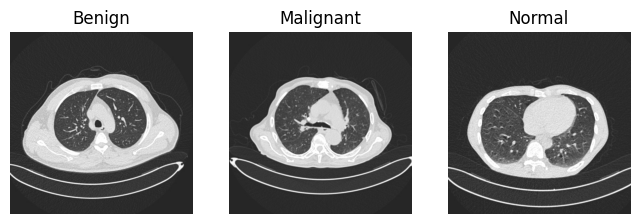

In [ ]:
train_dir = '/content/drive/MyDrive/IQ-OTHNCCD_split/train'

benign_train_dir = os.path.join(train_dir, 'benign')
malignant_train_dir = os.path.join(train_dir, 'malignant')
normal_train_dir = os.path.join(train_dir, 'normal')

def plot_sample_images_in_line(directories, categories, num_images=1):
    # Create a single figure for all images
    plt.figure(figsize=(8, 4))

    for i, (directory, category) in enumerate(zip(directories, categories)):
        # Get a list of image filenames
        image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

        if len(image_files) == 0:
            print(f"No images found in {directory} to plot.")
            continue

        # Select a random image
        selected_image = random.choice(image_files)
        image_path = os.path.join(directory, selected_image)
        img = Image.open(image_path)

        # Plot the image in the corresponding subplot
        plt.subplot(1, len(directories), i + 1)
        plt.imshow(img, cmap='gray')  # Use 'gray' if images are grayscale
        plt.title(f"{category}")
        plt.axis('off')

    plt.show()

# Define the directories and categories
directories = [benign_train_dir, malignant_train_dir, normal_train_dir]
categories = ['Benign', 'Malignant', 'Normal']

# Plot one image from each category in a single line
plot_sample_images_in_line(directories, categories, num_images=1)

# Visual comparision of CLAHE, unsharp masking, contrast stretching image enhancement methods

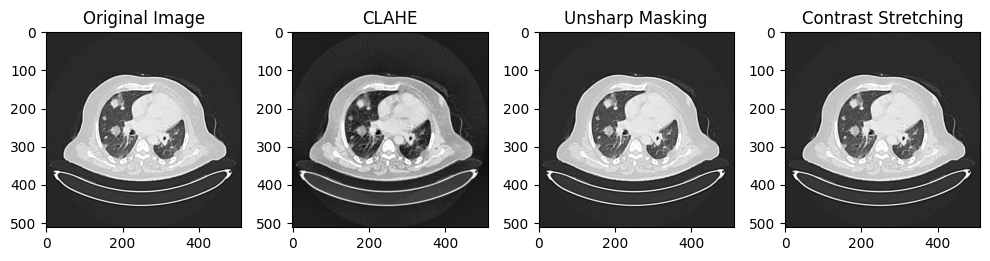

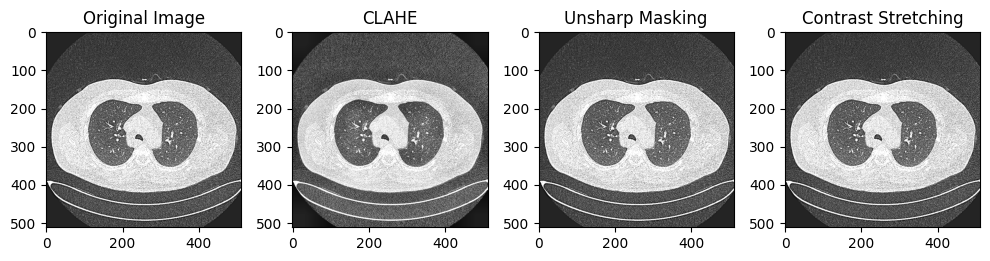

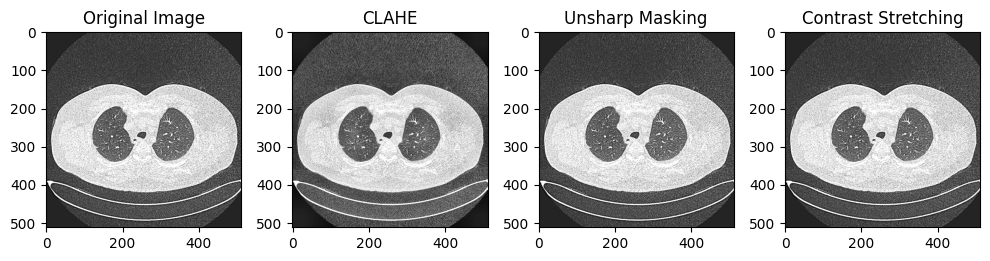

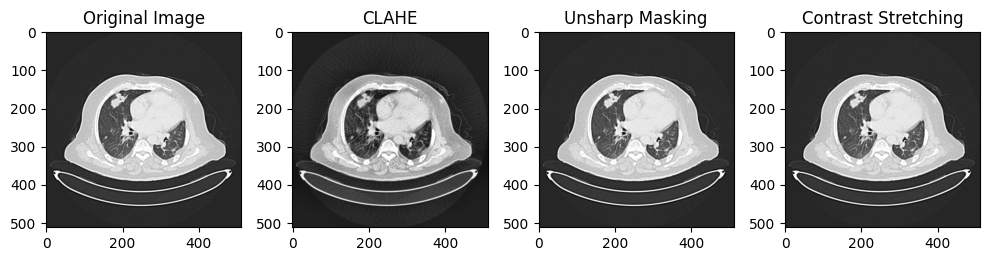

In [ ]:
# Function to apply CLAHE
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

# Function to apply Unsharp Masking
def apply_unsharp_masking(img):
    gaussian_blur = cv2.GaussianBlur(img, (9, 9), 10.0)
    return cv2.addWeighted(img, 1.5, gaussian_blur, -0.5, 0, img)

# Function to apply Contrast Stretching (Normalization)
def apply_contrast_stretching(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Function to apply Weighted Histogram Equalization
def apply_weighted_histogram(img):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    cdf_weighted = cdf * 255 / cdf[-1]  # Normalize the CDF
    img_weighted_histogram = np.interp(img.flatten(), bins[:-1], cdf_weighted)
    return img_weighted_histogram.reshape(img.shape).astype(np.uint8)

# Function to process and plot images
def process_and_plot_images():
    # Set paths to your training data images
    img_paths = [
        "/content/IQ-OTHNCCD_split/train/malignant/Malignant case (100).jpg",
        "/content/IQ-OTHNCCD_split/train/benign/Bengin case (108).jpg",
        "/content/IQ-OTHNCCD_split/train/benign/Bengin case (103).jpg",
        "/content/IQ-OTHNCCD_split/train/malignant/Malignant case (103).jpg"
    ]

    # Load and process each image
    for img_path in img_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error loading image {img_path}")
            continue

        # Apply each method
        img_clahe = apply_clahe(img)
        img_unsharp = apply_unsharp_masking(img)
        img_contrast_stretch = apply_contrast_stretching(img)
        img_weighted_hist = apply_weighted_histogram(img)

        # Plotting the original and processed images in a single line
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')

        plt.subplot(1, 4, 2)
        plt.imshow(img_clahe, cmap='gray')
        plt.title('CLAHE')

        plt.subplot(1, 4, 3)
        plt.imshow(img_unsharp, cmap='gray')
        plt.title('Unsharp Masking')

        plt.subplot(1, 4, 4)
        plt.imshow(img_contrast_stretch, cmap='gray')
        plt.title('Contrast Stretching')

        plt.tight_layout()
        plt.show()

# Run the function to process and plot images
process_and_plot_images()

# Applying CLAHE enhancement on all the images

In [ ]:
# Function to apply CLAHE
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

# Directory paths
input_train_dir = "/content/IQ-OTHNCCD_split/train"
output_train_dir = "/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Training_CLAHE"

# Create output directory if it doesn't exist
if not os.path.exists(output_train_dir):
    os.makedirs(output_train_dir)

# Process and save CLAHE-enhanced images
for category in ['benign', 'malignant', 'normal']:
    category_dir = os.path.join(input_train_dir, category)
    output_category_dir = os.path.join(output_train_dir, category)

    if not os.path.exists(output_category_dir):
        os.makedirs(output_category_dir)

    for filename in os.listdir(category_dir):
        img_path = os.path.join(category_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            img_clahe = apply_clahe(img)
            output_img_path = os.path.join(output_category_dir, filename)
            cv2.imwrite(output_img_path, img_clahe)
        else:
            print(f"Error loading image {img_path}")

print("CLAHE enhancement completed for all training images.")

CLAHE enhancement completed for all training images.


# Experimenting with CLAHE images

**1. Setup Environment**

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow keras opencv-python

**2. Load and Preprocess Data**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Directories
train_dir = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Training_CLAHE'
test_dir = '/content/drive/MyDrive/IQ-OTHNCCD_split/test'

# Image dimensions
img_width, img_height = 224, 224  # Adjust as needed

def load_images_from_directory(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            images.append(img)
            labels.append(label)
    return images, labels

# Load and prepare training and testing data
train_images, train_labels = [], []
for category, label in [('benign', 0), ('malignant', 1), ('normal', 2)]:
    category_images, category_labels = load_images_from_directory(os.path.join(train_dir, category), label)
    train_images.extend(category_images)
    train_labels.extend(category_labels)

test_images, test_labels = [], []
for category, label in [('benign', 0), ('malignant', 1), ('normal', 2)]:
    category_images, category_labels = load_images_from_directory(os.path.join(test_dir, category), label)
    test_images.extend(category_images)
    test_labels.extend(category_labels)

# Convert lists to arrays and normalize
train_images = np.array(train_images).astype('float32') / 255.0
test_images = np.array(test_images).astype('float32') / 255.0
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Convert labels to categorical format
train_labels_cat = to_categorical(train_labels, num_classes=3)
test_labels_cat = to_categorical(test_labels, num_classes=3)

**3. Define and Train Models**

# (i) LeNet-5 + SVM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten

# Create LeNet-5 model for feature extraction
def create_lenet5_feature_extractor():
    model = Sequential([
        Conv2D(6, (5, 5), activation='tanh', input_shape=(img_width, img_height, 1)),
        MaxPooling2D(),
        Conv2D(16, (5, 5), activation='tanh'),
        MaxPooling2D(),
        Flatten(),  # Flatten the feature maps
        Dense(120, activation='tanh'),
        Dense(84, activation='tanh'),
    ])
    return model

lenet5_feature_extractor = create_lenet5_feature_extractor()

# Extract features using LeNet-5
train_features_lenet5 = lenet5_feature_extractor.predict(train_images[..., np.newaxis])
test_features_lenet5 = lenet5_feature_extractor.predict(test_images[..., np.newaxis])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 604ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 836ms/step


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features_lenet5)
test_features = scaler.transform(test_features_lenet5)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_lenet5, train_labels)


SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict probabilities and class labels on the test set
svm_probabilities_lenet5 = svm_model.predict_proba(test_features_lenet5)
svm_predictions_lenet5 = svm_model.predict(test_features_lenet5)

# Calculate test accuracy
test_accuracy_lenet5 = accuracy_score(test_labels, svm_predictions_lenet5)
print(f"Test Accuracy: {test_accuracy_lenet5}")

# Calculate test loss (log loss)
test_loss_lenet5 = log_loss(test_labels, svm_probabilities_lenet5)
print(f"Test Loss: {test_loss_lenet5}")

# Print the classification report
print("Classification Report for LeNet-5 + SVM Model:\n")
print(classification_report(test_labels, svm_predictions_lenet5))

# Generate the confusion matrix
cm = confusion_matrix(test_labels, svm_predictions_lenet5)

# For a multi-class problem, we'll compute metrics for each class individually
# and then print them.
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, svm_predictions_lenet5, labels=[i], average='macro')
    recall = recall_score(test_labels, svm_predictions_lenet5, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()


Test Accuracy: 0.7757575757575758
Test Loss: 0.5232782594886074
Classification Report for LeNet-5 + SVM Model:

              precision    recall  f1-score   support

           0       0.90      0.25      0.39        36
           1       0.72      0.99      0.83       169
           2       0.90      0.64      0.75       125

    accuracy                           0.78       330
   macro avg       0.84      0.63      0.66       330
weighted avg       0.81      0.78      0.75       330

Class 0:
  Precision: 0.90
  Recall (Sensitivity): 0.25
  Specificity: 1.00
  TP: 9, TN: 293, FP: 1, FN: 27

Class 1:
  Precision: 0.72
  Recall (Sensitivity): 0.99
  Specificity: 0.60
  TP: 167, TN: 97, FP: 64, FN: 2

Class 2:
  Precision: 0.90
  Recall (Sensitivity): 0.64
  Specificity: 0.96
  TP: 80, TN: 196, FP: 9, FN: 45



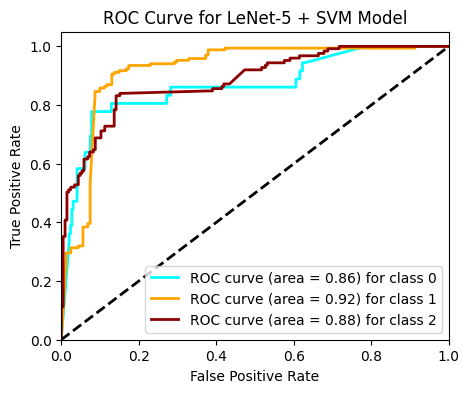

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Calculate test accuracy
test_accuracy_lenet5 = accuracy_score(test_labels, svm_predictions_lenet5)
print(f"Test Accuracy: {test_accuracy_lenet5}")

# Calculate test loss (log loss)
test_loss_lenet5 = log_loss(test_labels, svm_probabilities_lenet5)
print(f"Test Loss: {test_loss_lenet5}")
#  3 classes
n_classes = len(np.unique(test_labels))

# Binarize the labels for multi-class ROC curve
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2])

# Predict probabilities using the SVM model
svm_probabilities = svm_model.predict_proba(test_features)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5,4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LeNet-5 + SVM Model')
plt.legend(loc="lower right")
plt.show()


 # (ii) DenseNet-121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the DenseNet121 model
def create_densenet121_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Convert grayscale images to RGB
train_images_rgb = np.repeat(train_images[..., np.newaxis], 3, axis=-1)
test_images_rgb = np.repeat(test_images[..., np.newaxis], 3, axis=-1)

# Load DenseNet121 model and extract features
densenet121_model = create_densenet121_model()
feature_extractor = Model(inputs=densenet121_model.input, outputs=densenet121_model.layers[-2].output)

# Extract features
train_features_densenet121 = feature_extractor.predict(train_images_rgb)
test_features_densenet121 = feature_extractor.predict(test_images_rgb)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 198s 8s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

# Standardize features
scaler = StandardScaler()
train_features_densenet121 = scaler.fit_transform(train_features_densenet121)
test_features_densenet121 = scaler.transform(test_features_densenet121)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_densenet121, train_labels)


SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, log_loss
import numpy as np

# Predict class labels and probabilities using the SVM model
svm_predictions_densenet121 = svm_model.predict(test_features_densenet121)
svm_probabilities_densenet121 = svm_model.predict_proba(test_features_densenet121)

# Calculate overall accuracy
test_accuracy_densenet121 = accuracy_score(test_labels, svm_predictions_densenet121)
print(f"Test Accuracy: {test_accuracy_densenet121:.2f}")

# Calculate test loss (log loss)
test_loss_densenet121 = log_loss(test_labels_bin, svm_probabilities_densenet121)
print(f"Test Loss: {test_loss_densenet121:.2f}")

# Print the classification report
print("Classification Report for DenseNet121 + SVM Model:\n")
print(classification_report(test_labels, svm_predictions_densenet121))

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, svm_predictions_densenet121)

# For multi-class problems, calculate metrics for each class
n_classes = len(np.unique(test_labels))
for i in range(n_classes):
    tp = cm[i, i]  # True Positives for class i
    fp = cm[:, i].sum() - tp  # False Positives for class i
    fn = cm[i, :].sum() - tp  # False Negatives for class i
    tn = cm.sum() - (tp + fp + fn)  # True Negatives for class i

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, svm_predictions_densenet121, labels=[i], average='macro')
    recall = recall_score(test_labels, svm_predictions_densenet121, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Print confusion matrix
print("Confusion Matrix:\n", cm)



Test Accuracy: 0.81
Test Loss: 0.48
Classification Report for DenseNet121 + SVM Model:

              precision    recall  f1-score   support

           0       0.91      0.28      0.43        36
           1       0.80      0.99      0.88       169
           2       0.83      0.73      0.77       125

    accuracy                           0.81       330
   macro avg       0.85      0.66      0.69       330
weighted avg       0.82      0.81      0.79       330

Class 0:
  Precision: 0.91
  Recall (Sensitivity): 0.28
  Specificity: 1.00
  TP: 10, TN: 293, FP: 1, FN: 26

Class 1:
  Precision: 0.80
  Recall (Sensitivity): 0.99
  Specificity: 0.74
  TP: 167, TN: 119, FP: 42, FN: 2

Class 2:
  Precision: 0.83
  Recall (Sensitivity): 0.73
  Specificity: 0.91
  TP: 91, TN: 186, FP: 19, FN: 34

Confusion Matrix:
 [[ 10   9  17]
 [  0 167   2]
 [  1  33  91]]


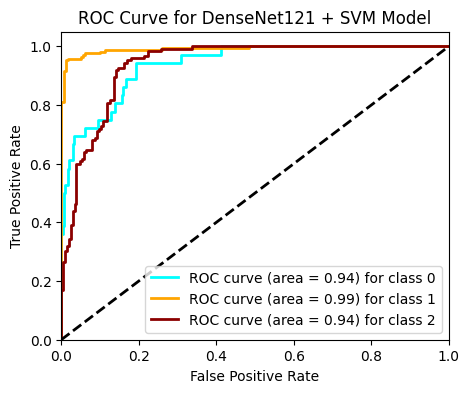

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities using the SVM model
svm_probabilities_densenet121 = svm_model.predict_proba(test_features_densenet121)

# Binarize the labels for multi-class ROC curve
n_classes = len(np.unique(test_labels))
test_labels_bin = label_binarize(test_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_densenet121[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5, 4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DenseNet121 + SVM Model')
plt.legend(loc="lower right")
plt.show()


# (iii) ResNet-50 + SVM

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert grayscale images to RGB
train_images_rgb = np.repeat(train_images[..., np.newaxis], 3, axis=-1)
test_images_rgb = np.repeat(test_images[..., np.newaxis], 3, axis=-1)

# Initialize and train the ResNet50 model
resnet50_model = create_resnet50_model()

# Extract features using the ResNet50 model
feature_extractor_resnet50 = Model(inputs=resnet50_model.input, outputs=resnet50_model.layers[-2].output)
train_features_resnet50 = feature_extractor_resnet50.predict(train_images_rgb)
test_features_resnet50 = feature_extractor_resnet50.predict(test_images_rgb)


24/24 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step


In [ ]:
# Standardize features
scaler = StandardScaler()
train_features_resnet50 = scaler.fit_transform(train_features_resnet50)
test_features_resnet50 = scaler.transform(test_features_resnet50)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_resnet50, train_labels)


SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, log_loss

# Predict probabilities and class labels on the test set
svm_probabilities_resnet50 = svm_model.predict_proba(test_features_resnet50)
svm_predictions_resnet50 = svm_model.predict(test_features_resnet50)

# Calculate test accuracy
test_accuracy_resnet50 = accuracy_score(test_labels, svm_predictions_resnet50)
print(f"Test Accuracy: {test_accuracy_resnet50:.2f}")

# Calculate test loss (log loss)
test_loss_resnet50 = log_loss(test_labels, svm_probabilities_resnet50)
print(f"Test Loss: {test_loss_resnet50:.2f}")

# Print classification report
print("\nClassification Report:\n", classification_report(test_labels, svm_predictions_resnet50))

# Compute confusion matrix
cm = confusion_matrix(test_labels, svm_predictions_resnet50)

# Compute precision, recall, sensitivity, specificity
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, svm_predictions_resnet50, labels=[i], average='macro')
    recall = recall_score(test_labels, svm_predictions_resnet50, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero

    print(f"\nClass {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")


Test Accuracy: 0.86
Test Loss: 0.44

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.81      0.67        36
           1       0.91      0.98      0.94       169
           2       0.92      0.72      0.81       125

    accuracy                           0.86       330
   macro avg       0.80      0.83      0.81       330
weighted avg       0.88      0.86      0.86       330


Class 0:
  Precision: 0.58
  Recall (Sensitivity): 0.81
  Specificity: 0.93
  TP: 29, TN: 273, FP: 21, FN: 7

Class 1:
  Precision: 0.91
  Recall (Sensitivity): 0.98
  Specificity: 0.89
  TP: 165, TN: 144, FP: 17, FN: 4

Class 2:
  Precision: 0.92
  Recall (Sensitivity): 0.72
  Specificity: 0.96
  TP: 90, TN: 197, FP: 8, FN: 35


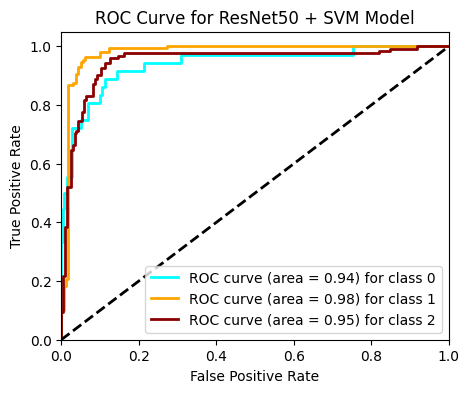

In [ ]:
# Binarize the labels for multi-class ROC curve
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2])

# Predict probabilities using the SVM model
svm_probabilities_resnet50 = svm_model.predict_proba(test_features_resnet50)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(test_labels_bin[0])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_resnet50[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5,4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ResNet50 + SVM Model')
plt.legend(loc="lower right")
plt.show()


# (iV) Deep Neural Network (DNN) + SVM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Define the Deep Neural Network (DNN) model
def create_dnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(3, activation='softmax')(x)  # Assuming 3 classes
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Flatten images
train_images_flatten = train_images.reshape((train_images.shape[0], -1))
test_images_flatten = test_images.reshape((test_images.shape[0], -1))

# Train the DNN model
input_shape = (train_images_flatten.shape[1],)  # Flattened input shape
dnn_model = create_dnn_model(input_shape)
dnn_model.fit(train_images_flatten, train_labels_cat, epochs=10, batch_size=32, validation_split=0.2)

# Create a feature extraction model
feature_extractor_dnn = Model(inputs=dnn_model.input, outputs=dnn_model.layers[-2].output)

# Extract features
train_features_dnn = feature_extractor_dnn.predict(train_images_flatten)
test_features_dnn = feature_extractor_dnn.predict(test_images_flatten)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.4746 - loss: 4.8944 - val_accuracy: 0.0000e+00 - val_loss: 9.4848
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.6516 - loss: 1.6419 - val_accuracy: 0.6039 - val_loss: 1.1841
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.7609 - loss: 0.6888 - val_accuracy: 0.7143 - val_loss: 0.5936
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.8311 - loss: 0.4125 - val_accuracy: 0.9026 - val_loss: 0.2797
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9526 - loss: 0.1752 - val_accuracy: 0.5714 - val_loss: 0.9701
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9495 - loss: 0.1344 - val_accuracy: 0.9870 - val_loss: 0.0754
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9265 - loss: 0.2099 - val_accuracy: 0.9740 - val_loss: 0.1081
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9636 - loss: 0.1634 - val_accuracy

In [ ]:
# Train the SVM model
scaler = StandardScaler()
train_features_dnn = scaler.fit_transform(train_features_dnn)
test_features_dnn = scaler.transform(test_features_dnn)

svm_model_dnn = SVC(kernel='linear', probability=True)
svm_model_dnn.fit(train_features_dnn, train_labels)

# Predict class labels on the test set
svm_predictions_dnn = svm_model.predict(test_features_dnn)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

# Predict class labels on the test set
svm_predictions_dnn = svm_model.predict(test_features_dnn)
svm_probabilities_dnn = svm_model.predict_proba(test_features_dnn)

# Print test loss and accuracy
# For SVM, we don't have loss during prediction, so we will use accuracy
test_accuracy_dnn = np.mean(svm_predictions_dnn == test_labels)
print(f"Test Accuracy: {test_accuracy_dnn:.2f}")

# SVM does not have a direct 'loss' measure like neural networks
# We use log_loss as an approximation for the test loss
from sklearn.metrics import log_loss
test_loss_dnn = log_loss(test_labels, svm_probabilities)
print(f"Test Loss: {test_loss_dnn:.2f}")

# Print classification report
print("SVM Classification Report:\n", classification_report(test_labels, svm_predictions_dnn))

# Generate the confusion matrix
cm = confusion_matrix(test_labels, svm_predictions_dnn)

# Calculate precision, recall (sensitivity), specificity for each class
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, svm_predictions_dnn, labels=[i], average='macro')
    recall = recall_score(test_labels, svm_predictions_dnn, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()


Test Accuracy: 0.96
Test Loss: 3.47
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.93      1.00      0.97       169
           2       1.00      0.90      0.95       125

    accuracy                           0.96       330
   macro avg       0.96      0.96      0.96       330
weighted avg       0.96      0.96      0.96       330

Class 0:
  Precision: 0.95
  Recall (Sensitivity): 0.97
  Specificity: 0.99
  TP: 35, TN: 292, FP: 2, FN: 1

Class 1:
  Precision: 0.93
  Recall (Sensitivity): 1.00
  Specificity: 0.93
  TP: 169, TN: 149, FP: 12, FN: 0

Class 2:
  Precision: 1.00
  Recall (Sensitivity): 0.90
  Specificity: 1.00
  TP: 112, TN: 205, FP: 0, FN: 13



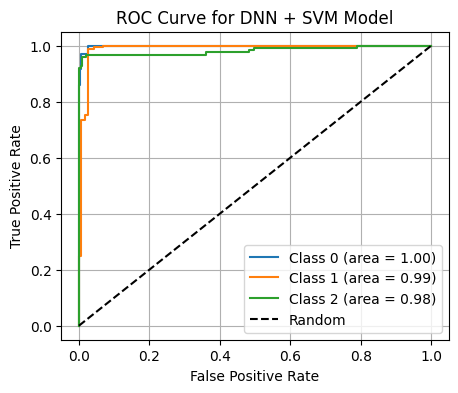

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2])
n_classes = test_labels_bin.shape[1]

# Get predicted probabilities for each class
svm_probabilities_dnn = svm_model.predict_proba(test_features_dnn)

# Initialize the plot
plt.figure(figsize=(5,4))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], svm_probabilities_dnn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DNN + SVM Model')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


# (v) CNN + SVM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),  # Flatten the feature maps
        Dense(128, activation='relu'),  # Dense layer for feature extraction
    ])
    return model

cnn_model = create_cnn_model()

# Extract features using the CNN
train_features_cnn = cnn_model.predict(train_images[..., np.newaxis])
test_features_cnn = cnn_model.predict(test_images[..., np.newaxis])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC

svm_model = SVC(probability=True)  # Initialize SVM classifier, enable probability estimates
svm_model.fit(train_features_cnn, train_labels)
# Predict probabilities on the test set
svm_probabilities_cnn = svm_model.predict_proba(test_features_cnn)

# Predict class labels on the test set
svm_predictions_cnn  = svm_model.predict(test_features_cnn)

# Calculate test accuracy
test_accuracy_cnn  = accuracy_score(test_labels, svm_predictions_cnn )
print(f"Test Accuracy: {test_accuracy_cnn }")

# Calculate test loss (log loss)
test_loss_cnn  = log_loss(test_labels, svm_probabilities_cnn )
print(f"Test Loss: {test_loss_cnn }")


Test Accuracy: 0.806060606060606
Test Loss: 0.3573408065909715


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report


# Standardize features
scaler = StandardScaler()
train_features_cnn = scaler.fit_transform(train_features_cnn)
test_features_cnn = scaler.transform(test_features_cnn)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_cnn, train_labels)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, svm_predictions_cnn)
# and then print them.
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, svm_predictions_cnn, labels=[i], average='macro')
    recall = recall_score(test_labels, svm_predictions_cnn, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Evaluate SVM model
svm_predictions_cnn = svm_model.predict(test_features_cnn)
print("SVM Classification Report:\n", classification_report(test_labels, svm_predictions_cnn))
print("SVM Confusion Matrix:\n", confusion_matrix(test_labels, svm_predictions_cnn))


Class 0:
  Precision: 0.83
  Recall (Sensitivity): 0.14
  Specificity: 1.00
  TP: 5, TN: 293, FP: 1, FN: 31

Class 1:
  Precision: 0.76
  Recall (Sensitivity): 1.00
  Specificity: 0.68
  TP: 169, TN: 109, FP: 52, FN: 0

Class 2:
  Precision: 0.89
  Recall (Sensitivity): 0.74
  Specificity: 0.95
  TP: 92, TN: 194, FP: 11, FN: 33

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67        36
           1       0.83      1.00      0.91       169
           2       0.97      0.70      0.81       125

    accuracy                           0.85       330
   macro avg       0.82      0.79      0.80       330
weighted avg       0.87      0.85      0.85       330

SVM Confusion Matrix:
 [[ 24   9   3]
 [  0 169   0]
 [ 12  25  88]]


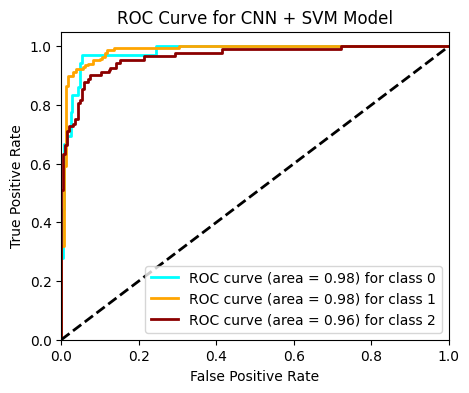

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities using the SVM model
svm_probabilities_cnn  = svm_model.predict_proba(test_features_cnn)

# Binarize the labels for multi-class ROC curve
n_classes = len(np.unique(test_labels))
test_labels_bin = label_binarize(test_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_cnn [:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5, 4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN + SVM Model')
plt.legend(loc="lower right")
plt.show()


# (vi) VGG16 + SVM

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, log_loss
import numpy as np

# Define VGG16 model as feature extractor
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Convert grayscale images to RGB
train_images_rgb = np.repeat(train_images[..., np.newaxis], 3, axis=-1)
test_images_rgb = np.repeat(test_images[..., np.newaxis], 3, axis=-1)

# Create and use VGG16 model to extract features
vgg16_model = create_vgg16_model()
train_features_vgg16 = vgg16_model.predict(train_images_rgb)
test_features_vgg16 = vgg16_model.predict(test_images_rgb)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 604s 24s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 203s 18s/step


In [ ]:
# Standardize features
scaler = StandardScaler()
train_features_vgg16 = scaler.fit_transform(train_features_vgg16)
test_features_vgg16 = scaler.transform(test_features_vgg16)

# Train SVM classifier
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_vgg16, train_labels)

# Predict class labels and probabilities
svm_predictions_vgg16 = svm_model.predict(test_features_vgg16)
svm_probabilities_vgg16 = svm_model.predict_proba(test_features_vgg16)


In [ ]:
# Calculate test accuracy
test_accuracy_vgg16 = np.mean(svm_predictions_vgg16 == test_labels)
print(f"Test Accuracy: {test_accuracy_vgg16:.2f}")

# Calculate test loss using log loss
test_loss_vgg16 = log_loss(test_labels, svm_probabilities_vgg16)
print(f"Test Loss: {test_loss_vgg16:.2f}")

# Generate confusion matrix
cm = confusion_matrix(test_labels, svm_predictions_vgg16)

# Print confusion matrix
print("Confusion Matrix:\n", cm)

# Calculate TP, TN, FP, FN for each class
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, svm_predictions_vgg16, labels=[i], average='macro')
    recall = recall_score(test_labels, svm_predictions_vgg16, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Print classification report
print("Classification Report:\n", classification_report(test_labels, svm_predictions_vgg16))

Test Accuracy: 0.71
Test Loss: 0.63
Confusion Matrix:
 [[ 27   2   7]
 [  8 157   4]
 [ 62  12  51]]
Class 0:
  Precision: 0.28
  Recall (Sensitivity): 0.75
  Specificity: 0.76
  TP: 27, TN: 224, FP: 70, FN: 9

Class 1:
  Precision: 0.92
  Recall (Sensitivity): 0.93
  Specificity: 0.91
  TP: 157, TN: 147, FP: 14, FN: 12

Class 2:
  Precision: 0.82
  Recall (Sensitivity): 0.41
  Specificity: 0.95
  TP: 51, TN: 194, FP: 11, FN: 74

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.75      0.41        36
           1       0.92      0.93      0.92       169
           2       0.82      0.41      0.55       125

    accuracy                           0.71       330
   macro avg       0.67      0.70      0.62       330
weighted avg       0.81      0.71      0.72       330



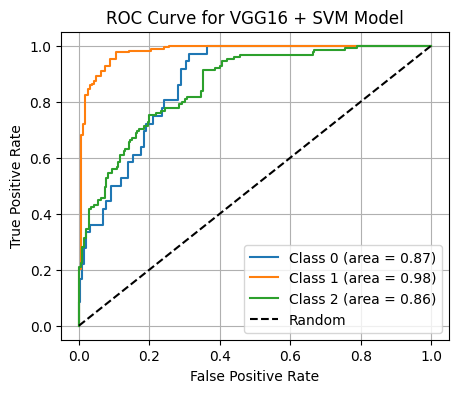

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2])
n_classes = test_labels_bin.shape[1]

# Get predicted probabilities for each class
svm_probabilities_vgg16 = svm_model.predict_proba(test_features_vgg16)

# Initialize the plot
plt.figure(figsize=(5,4))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], svm_probabilities_vgg16[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for VGG16 + SVM Model')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


# (vii) GoogleNet + SVM classifier

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

img_width, img_height = 224,224 # Required size for InceptionV3

# Step 1: Define the GoogLeNet (InceptionV3) model for feature extraction
def create_googlenet_feature_extractor():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)  # Output the features instead of classification
    return model

# Convert grayscale images to RGB if needed
train_images_rgb = np.repeat(train_images[..., np.newaxis], 3, axis=-1)
test_images_rgb = np.repeat(test_images[..., np.newaxis], 3, axis=-1)

# Step 2: Extract deep features using GoogLeNet (InceptionV3)
googlenet_feature_extractor = create_googlenet_feature_extractor()
train_features = googlenet_feature_extractor.predict(train_images_rgb)
test_features = googlenet_feature_extractor.predict(test_images_rgb)

# Step 3: Train the SVM on the extracted features
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
svm_classifier.fit(train_features, np.argmax(train_labels_cat, axis=1))

# Step 4: Evaluate the SVM model on the test data
test_predictions = svm_classifier.predict(test_features)
test_accuracy = np.mean(test_predictions == np.argmax(test_labels_cat, axis=1))

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
# and then print them.
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, test_predictions , labels=[i], average='macro')
    recall = recall_score(test_labels, test_predictions , labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Step 5: Print evaluation metrics
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_report(np.argmax(test_labels_cat, axis=1), test_predictions))
print('Confusion Matrix:')
print(confusion_matrix(np.argmax(test_labels_cat, axis=1), test_predictions))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 75s 7s/step
Class 0:
  Precision: 0.35
  Recall (Sensitivity): 0.92
  Specificity: 0.79
  TP: 33, TN: 233, FP: 61, FN: 3

Class 1:
  Precision: 0.94
  Recall (Sensitivity): 0.99
  Specificity: 0.94
  TP: 168, TN: 151, FP: 10, FN: 1

Class 2:
  Precision: 1.00
  Recall (Sensitivity): 0.46
  Specificity: 1.00
  TP: 58, TN: 205, FP: 0, FN: 67

Test Accuracy: 78.48%
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.92      0.51        36
           1       0.94      0.99      0.97       169
           2       1.00      0.46      0.63       125

    accuracy                           0.78       330
   macro avg       0.76      0.79      0.70       330
weighted avg       0.90      0.78      0.79       330

Confusion Matrix:
[[ 33   3   0]
 [  1 168   0]
 [ 60   7  58]]


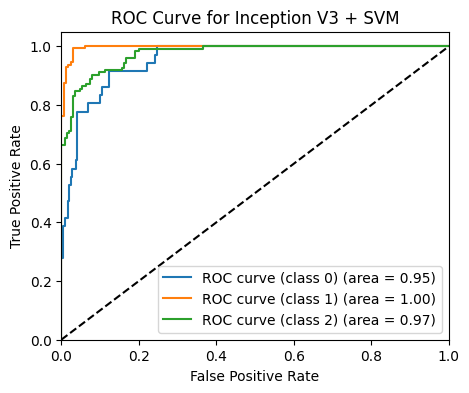

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Calculate ROC curve and AUC
svm_probabilities = svm_classifier.predict_proba(test_features)
fpr = {}
tpr = {}
roc_auc = {}

# Binarize the test labels for multi-class ROC
test_labels_bin = label_binarize(np.argmax(test_labels_cat, axis=1),
                                 classes=np.unique(np.argmax(test_labels_cat, axis=1)))
n_classes = test_labels_bin.shape[1]

# Calculate fpr, tpr, and roc_auc for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(5,4))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Inception V3 + SVM')
plt.legend(loc='lower right')
plt.show()

# Apply unsharp masking on all the images

In [ ]:
import cv2
import numpy as np
import os

# Function to apply Unsharp Masking
def apply_unsharp_mask(img, sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(img, (0, 0), sigma)
    sharpened = cv2.addWeighted(img, 1.0 + strength, blurred, -strength, 0)
    return sharpened

# Directory paths
input_train_dir = "/content/drive/MyDrive/IQ-OTHNCCD_split/train"
output_train_dir = "/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Training_Unsharp_Masked"

# Create output directory if it doesn't exist
if not os.path.exists(output_train_dir):
    os.makedirs(output_train_dir)

# Process and save Unsharp Masked images
for category in ['benign', 'malignant', 'normal']:
    category_dir = os.path.join(input_train_dir, category)
    output_category_dir = os.path.join(output_train_dir, category)

    if not os.path.exists(output_category_dir):
        os.makedirs(output_category_dir)

    if os.path.exists(category_dir):
        for filename in os.listdir(category_dir):
            img_path = os.path.join(category_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img_unsharp = apply_unsharp_mask(img)
                output_img_path = os.path.join(output_category_dir, filename)
                cv2.imwrite(output_img_path, img_unsharp)
            else:
                print(f"Error loading image {img_path}")
    else:
        print(f"Directory not found: {category_dir}") # Print a message if the directory is not found

print("Unsharp Masking completed for all training images.")

Unsharp Masking completed for all training images.


# Experimenting with Unsharp masking images

**1. Setup Environment**

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow keras opencv-python

**2. Load and preprocess the data**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Directories
train_dir_unsharp_masking = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Training_Unsharp_Masked'
test_dir = '/content/drive/MyDrive/IQ-OTHNCCD_split/test'

# Image dimensions
img_width, img_height = 224, 224  # Adjust as needed

def load_images_from_directory(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            images.append(img)
            labels.append(label)
    return images, labels

# Load and prepare training and testing data
train_images_unsharp_masking, train_labels_unsharp_masking = [], []
for category, label in [('benign', 0), ('malignant', 1), ('normal', 2)]:
    category_images, category_labels = load_images_from_directory(os.path.join(train_dir_unsharp_masking, category), label)
    train_images_unsharp_masking.extend(category_images)
    train_labels_unsharp_masking.extend(category_labels)

test_images_unsharp_masking, test_labels_unsharp_masking = [], []
for category, label in [('benign', 0), ('malignant', 1), ('normal', 2)]:
    category_images, category_labels = load_images_from_directory(os.path.join(test_dir, category), label)
    test_images_unsharp_masking.extend(category_images)
    test_labels_unsharp_masking.extend(category_labels)

# Convert lists to arrays and normalize
train_images_unsharp_masking = np.array(train_images_unsharp_masking).astype('float32') / 255.0
test_images_unsharp_masking = np.array(test_images_unsharp_masking).astype('float32') / 255.0
train_labels_unsharp_masking = np.array(train_labels_unsharp_masking)
test_labels_unsharp_masking = np.array(test_labels_unsharp_masking)

# Convert labels to categorical format
train_labels_cat_unsharp_masking = to_categorical(train_labels_unsharp_masking, num_classes=3)
test_labels_cat_unsharp_masking = to_categorical(test_labels_unsharp_masking, num_classes=3)

**3. Define and Train Models**

# (i) LeNet-5 + SVM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten

# Create LeNet-5 model for feature extraction
def create_lenet5_feature_extractor():
    model = Sequential([
        Conv2D(6, (5, 5), activation='tanh', input_shape=(img_width, img_height, 1)),
        MaxPooling2D(),
        Conv2D(16, (5, 5), activation='tanh'),
        MaxPooling2D(),
        Flatten(),  # Flatten the feature maps
        Dense(120, activation='tanh'),
        Dense(84, activation='tanh'),
    ])
    return model

lenet5_feature_extractor = create_lenet5_feature_extractor()

# Extract features using LeNet-5
train_features_lenet5_unsharp_masking = lenet5_feature_extractor.predict(train_images_unsharp_masking[..., np.newaxis])
test_features_lenet5_unsharp_masking = lenet5_feature_extractor.predict(test_images_unsharp_masking[..., np.newaxis])

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 611ms/step


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
train_features_lenet5_unsharp_masking = scaler.fit_transform(train_features_lenet5_unsharp_masking)
test_features_lenet5_unsharp_masking = scaler.transform(test_features_lenet5_unsharp_masking)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_lenet5_unsharp_masking, train_labels)

SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict probabilities and class labels on the test set
svm_probabilities_lenet5_unsharp_masking = svm_model.predict_proba(test_features_lenet5_unsharp_masking)
svm_predictions_lenet5_unsharp_masking = svm_model.predict(test_features_lenet5_unsharp_masking)

# Calculate test accuracy
test_accuracy_lenet5_unsharp_masking = accuracy_score(test_labels, svm_predictions_lenet5_unsharp_masking)
print(f"Test Accuracy: {test_accuracy_lenet5_unsharp_masking}")

# Calculate test loss (log loss)
test_loss_lenet5_unsharp_masking = log_loss(test_labels, svm_probabilities_lenet5_unsharp_masking)
print(f"Test Loss: {test_loss_lenet5_unsharp_masking}")

# Print the classification report
print("Classification Report for LeNet-5 + SVM Model:\n")
print(classification_report(test_labels, svm_predictions_lenet5_unsharp_masking))

# Generate the confusion matrix
cm = confusion_matrix(test_labels, svm_predictions_lenet5_unsharp_masking)

# For a multi-class problem, we'll compute metrics for each class individually
# and then print them.
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, svm_predictions_lenet5_unsharp_masking, labels=[i], average='macro')
    recall = recall_score(test_labels, svm_predictions_lenet5_unsharp_masking, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()


Test Accuracy: 0.8272727272727273
Test Loss: 0.4447387477221682
Classification Report for LeNet-5 + SVM Model:

              precision    recall  f1-score   support

           0       0.74      0.69      0.71        36
           1       0.80      0.99      0.89       169
           2       0.92      0.64      0.75       125

    accuracy                           0.83       330
   macro avg       0.82      0.78      0.79       330
weighted avg       0.84      0.83      0.82       330

Class 0:
  Precision: 0.74
  Recall (Sensitivity): 0.69
  Specificity: 0.97
  TP: 25, TN: 285, FP: 9, FN: 11

Class 1:
  Precision: 0.80
  Recall (Sensitivity): 0.99
  Specificity: 0.75
  TP: 168, TN: 120, FP: 41, FN: 1

Class 2:
  Precision: 0.92
  Recall (Sensitivity): 0.64
  Specificity: 0.97
  TP: 80, TN: 198, FP: 7, FN: 45



Test Accuracy: 0.8272727272727273
Test Loss: 0.4447387477221682


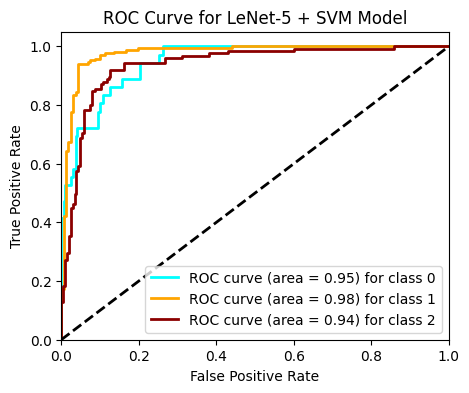

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Calculate test accuracy
test_accuracy_lenet5_unsharp_masking = accuracy_score(test_labels, svm_predictions_lenet5_unsharp_masking)
print(f"Test Accuracy: {test_accuracy_lenet5_unsharp_masking}")

# Calculate test loss (log loss)
test_loss_lenet5_unsharp_masking = log_loss(test_labels, svm_probabilities_lenet5_unsharp_masking)
print(f"Test Loss: {test_loss_lenet5_unsharp_masking}")
#  3 classes
n_classes = len(np.unique(test_labels_unsharp_masking))

# Binarize the labels for multi-class ROC curve
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2])

# Predict probabilities using the SVM model
svm_probabilities_unsharp_masking = svm_model.predict_proba(test_features_lenet5_unsharp_masking)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_unsharp_masking[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5,4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LeNet-5 + SVM Model')
plt.legend(loc="lower right")
plt.show()

# (ii) DenseNet-121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the DenseNet121 model
def create_densenet121_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Convert grayscale images to RGB
train_images_rgb_unsharp_masking = np.repeat(train_images_unsharp_masking[..., np.newaxis], 3, axis=-1)
test_images_rgb_unsharp_masking = np.repeat(test_images_unsharp_masking[..., np.newaxis], 3, axis=-1)

# Load DenseNet121 model and extract features
densenet121_model_unsharp_masking = create_densenet121_model()
feature_extractor_unsharp_masking = Model(inputs=densenet121_model_unsharp_masking.input, outputs=densenet121_model_unsharp_masking.layers[-2].output)

# Extract features
train_features_densenet121_unsharp_masking = feature_extractor_unsharp_masking.predict(train_images_rgb_unsharp_masking)
test_features_densenet121_unsharp_masking = feature_extractor_unsharp_masking.predict(test_images_rgb_unsharp_masking)


24/24 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

# Standardize features
scaler = StandardScaler()
train_features_densenet121_unsharp_masking = scaler.fit_transform(train_features_densenet121_unsharp_masking)
test_features_densenet121_unsharp_masking = scaler.transform(test_features_densenet121_unsharp_masking)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_densenet121_unsharp_masking, train_labels)

SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, log_loss
import numpy as np

# Predict class labels and probabilities using the SVM model
svm_predictions_densenet121_unsharp_masking = svm_model.predict(test_features_densenet121_unsharp_masking)
svm_probabilities_densenet121_unsharp_masking = svm_model.predict_proba(test_features_densenet121_unsharp_masking)

# Calculate overall accuracy
test_accuracy_densenet121_unsharp_masking = accuracy_score(test_labels, svm_predictions_densenet121_unsharp_masking)
print(f"Test Accuracy: {test_accuracy_densenet121_unsharp_masking:.2f}")

# Calculate test loss (log loss)
test_loss_densenet121_unsharp_masking = log_loss(test_labels_bin, svm_probabilities_densenet121_unsharp_masking)
print(f"Test Loss: {test_loss_densenet121_unsharp_masking:.2f}")

# Print the classification report
print("Classification Report for DenseNet121 + SVM Model:\n")
print(classification_report(test_labels, svm_predictions_densenet121_unsharp_masking))

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, svm_predictions_densenet121_unsharp_masking)

# For multi-class problems, calculate metrics for each class
n_classes = len(np.unique(test_labels))
for i in range(n_classes):
    tp = cm[i, i]  # True Positives for class i
    fp = cm[:, i].sum() - tp  # False Positives for class i
    fn = cm[i, :].sum() - tp  # False Negatives for class i
    tn = cm.sum() - (tp + fp + fn)  # True Negatives for class i

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, svm_predictions_densenet121_unsharp_masking, labels=[i], average='macro')
    recall = recall_score(test_labels, svm_predictions_densenet121_unsharp_masking, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Print confusion matrix
print("Confusion Matrix:\n", cm)


Test Accuracy: 0.84
Test Loss: 0.41
Classification Report for DenseNet121 + SVM Model:

              precision    recall  f1-score   support

           0       0.78      0.58      0.67        36
           1       0.81      1.00      0.89       169
           2       0.94      0.70      0.80       125

    accuracy                           0.84       330
   macro avg       0.84      0.76      0.79       330
weighted avg       0.85      0.84      0.84       330

Class 0:
  Precision: 0.78
  Recall (Sensitivity): 0.58
  Specificity: 0.98
  TP: 21, TN: 288, FP: 6, FN: 15

Class 1:
  Precision: 0.81
  Recall (Sensitivity): 1.00
  Specificity: 0.75
  TP: 169, TN: 121, FP: 40, FN: 0

Class 2:
  Precision: 0.94
  Recall (Sensitivity): 0.70
  Specificity: 0.97
  TP: 88, TN: 199, FP: 6, FN: 37

Confusion Matrix:
 [[ 21   9   6]
 [  0 169   0]
 [  6  31  88]]


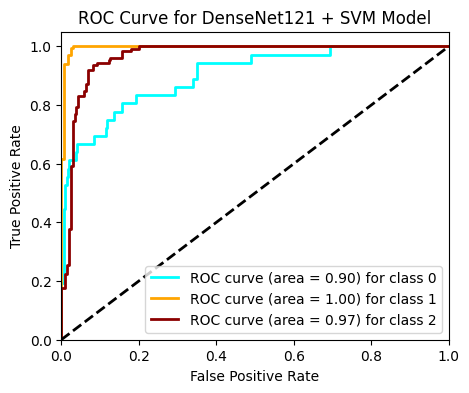

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities using the SVM model
svm_probabilities_densenet121_unsharp_masking = svm_model.predict_proba(test_features_densenet121_unsharp_masking)

# Binarize the labels for multi-class ROC curve
n_classes = len(np.unique(test_labels))
test_labels_bin = label_binarize(test_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_densenet121_unsharp_masking[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5, 4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DenseNet121 + SVM Model')
plt.legend(loc="lower right")
plt.show()


# (iii) ResNet-50 + SVM

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert grayscale images to RGB
train_images_rgb_unsharp_masking = np.repeat(train_images_unsharp_masking[..., np.newaxis], 3, axis=-1)
test_images_rgb_unsharp_masking = np.repeat(test_images_unsharp_masking[..., np.newaxis], 3, axis=-1)

# Initialize and train the ResNet50 model
resnet50_model = create_resnet50_model()

# Extract features using the ResNet50 model
feature_extractor_resnet50_unsharp_masking = Model(inputs=resnet50_model.input, outputs=resnet50_model.layers[-2].output)
train_features_resnet50_unsharp_masking = feature_extractor_resnet50_unsharp_masking.predict(train_images_rgb_unsharp_masking)
test_features_resnet50_unsharp_masking = feature_extractor_resnet50_unsharp_masking.predict(test_images_rgb_unsharp_masking)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step


In [ ]:
# Standardize features
scaler = StandardScaler()
train_features_resnet50_unsharp_masking = scaler.fit_transform(train_features_resnet50_unsharp_masking)
test_features_resnet50_unsharp_masking = scaler.transform(test_features_resnet50_unsharp_masking)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_resnet50_unsharp_masking, train_labels_unsharp_masking)

SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, log_loss

# Predict probabilities and class labels on the test set
svm_probabilities_resnet50_unsharp_masking = svm_model.predict_proba(test_features_resnet50_unsharp_masking)
svm_predictions_resnet50_unsharp_masking = svm_model.predict(test_features_resnet50_unsharp_masking)

# Calculate test accuracy
test_accuracy_resnet50_unsharp_masking = accuracy_score(test_labels_unsharp_masking, svm_predictions_resnet50_unsharp_masking)
print(f"Test Accuracy: {test_accuracy_resnet50_unsharp_masking:.2f}")

# Calculate test loss (log loss)
test_loss_resnet50_unsharp_masking = log_loss(test_labels_unsharp_masking, svm_probabilities_resnet50_unsharp_masking)
print(f"Test Loss: {test_loss_resnet50_unsharp_masking:.2f}")

# Print classification report
print("\nClassification Report:\n", classification_report(test_labels_unsharp_masking, svm_predictions_resnet50_unsharp_masking))

# Compute confusion matrix
cm = confusion_matrix(test_labels_unsharp_masking, svm_predictions_resnet50_unsharp_masking)

# Compute precision, recall, sensitivity, specificity
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_unsharp_masking, svm_predictions_resnet50_unsharp_masking, labels=[i], average='macro')
    recall = recall_score(test_labels_unsharp_masking, svm_predictions_resnet50_unsharp_masking, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero

    print(f"\nClass {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

Test Accuracy: 0.82
Test Loss: 0.56

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.28      0.38        36
           1       0.81      1.00      0.89       169
           2       0.87      0.73      0.79       125

    accuracy                           0.82       330
   macro avg       0.77      0.67      0.69       330
weighted avg       0.81      0.82      0.80       330


Class 0:
  Precision: 0.62
  Recall (Sensitivity): 0.28
  Specificity: 0.98
  TP: 10, TN: 288, FP: 6, FN: 26

Class 1:
  Precision: 0.81
  Recall (Sensitivity): 1.00
  Specificity: 0.75
  TP: 169, TN: 121, FP: 40, FN: 0

Class 2:
  Precision: 0.87
  Recall (Sensitivity): 0.73
  Specificity: 0.93
  TP: 91, TN: 191, FP: 14, FN: 34


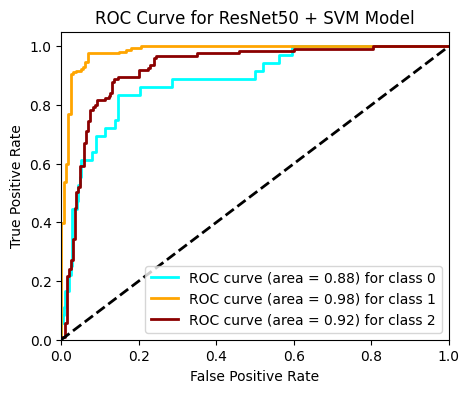

In [ ]:
# Binarize the labels for multi-class ROC curve
test_labels_bin = label_binarize(test_labels_unsharp_masking, classes=[0, 1, 2])

# Predict probabilities using the SVM model
svm_probabilities_resnet50_unsharp_masking = svm_model.predict_proba(test_features_resnet50_unsharp_masking)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(test_labels_bin[0])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_resnet50_unsharp_masking[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5,4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ResNet50 + SVM Model')
plt.legend(loc="lower right")
plt.show()

# (iV) Deep Neural Network (DNN) + SVM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Define the Deep Neural Network (DNN) model
def create_dnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(3, activation='softmax')(x)  # Assuming 3 classes
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Flatten images
train_images_flatten_unsharp_masking = train_images_unsharp_masking .reshape((train_images_unsharp_masking .shape[0], -1))
test_images_flatten_unsharp_masking  = test_images_unsharp_masking .reshape((test_images_unsharp_masking .shape[0], -1))

# Train the DNN model
input_shape = (train_images_flatten_unsharp_masking .shape[1],)  # Flattened input shape
dnn_model = create_dnn_model(input_shape)
dnn_model.fit(train_images_flatten_unsharp_masking , train_labels_cat_unsharp_masking , epochs=10, batch_size=32, validation_split=0.2)

# Create a feature extraction model
feature_extractor_dnn_unsharp_masking = Model(inputs=dnn_model.input, outputs=dnn_model.layers[-2].output)

# Extract features
train_features_dnn_unsharp_masking = feature_extractor_dnn_unsharp_masking .predict(train_images_flatten_unsharp_masking )
test_features_dnn_unsharp_masking  = feature_extractor_dnn_unsharp_masking .predict(test_images_flatten_unsharp_masking )

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.5221 - loss: 7.3870 - val_accuracy: 0.0000e+00 - val_loss: 6.1659
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5478 - loss: 2.0253 - val_accuracy: 0.5649 - val_loss: 1.1135
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8467 - loss: 0.3695 - val_accuracy: 0.1039 - val_loss: 2.0937
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8998 - loss: 0.2838 - val_accuracy: 0.8896 - val_loss: 0.2815
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9206 - loss: 0.2007 - val_accuracy: 0.3766 - val_loss: 1.5749
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9084 - loss: 0.2150 - val_accuracy: 0.6948 - val_loss: 0.7897
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9664 - loss: 0.1118 - val_accuracy: 0.3377 - val_loss: 1.6006
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9490 - loss: 0.1247 - val_accuracy: 0.59

In [ ]:
# Train the SVM model
scaler = StandardScaler()
train_features_dnn_unsharp_masking = scaler.fit_transform(train_features_dnn_unsharp_masking)
test_features_dnn_unsharp_masking = scaler.transform(test_features_dnn_unsharp_masking)

svm_model_dnn = SVC(kernel='linear', probability=True)
svm_model_dnn.fit(train_features_dnn_unsharp_masking, train_labels_unsharp_masking)

# Predict class labels on the test set
svm_predictions_dnn_unsharp_masking = svm_model_dnn.predict(test_features_dnn_unsharp_masking)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

# Predict class labels on the test set
svm_predictions_dnn_unsharp_masking = svm_model_dnn.predict(test_features_dnn_unsharp_masking)
svm_probabilities_dnn_unsharp_masking = svm_model_dnn.predict_proba(test_features_dnn_unsharp_masking)

# Print test loss and accuracy
# For SVM, we don't have loss during prediction, so we will use accuracy
test_accuracy_dnn_unsharp_masking = np.mean(svm_predictions_dnn_unsharp_masking == test_labels_unsharp_masking)
print(f"Test Accuracy: {test_accuracy_dnn_unsharp_masking:.2f}")

# SVM does not have a direct 'loss' measure like neural networks
# We use log_loss as an approximation for the test loss
from sklearn.metrics import log_loss
test_loss_dnn_unsharp_masking = log_loss(test_labels_unsharp_masking, svm_probabilities_dnn_unsharp_masking)
print(f"Test Loss: {test_loss_dnn_unsharp_masking:.2f}")

# Print classification report
print("SVM Classification Report:\n", classification_report(test_labels_unsharp_masking, svm_predictions_dnn_unsharp_masking))

# Generate the confusion matrix
cm = confusion_matrix(test_labels_unsharp_masking, svm_predictions_dnn_unsharp_masking)

# Calculate precision, recall (sensitivity), specificity for each class
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_unsharp_masking, svm_predictions_dnn_unsharp_masking, labels=[i], average='macro')
    recall = recall_score(test_labels_unsharp_masking, svm_predictions_dnn_unsharp_masking, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

Test Accuracy: 0.95
Test Loss: 0.15
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84        36
           1       0.99      0.98      0.99       169
           2       0.92      0.96      0.94       125

    accuracy                           0.95       330
   macro avg       0.94      0.91      0.92       330
weighted avg       0.95      0.95      0.95       330

Class 0:
  Precision: 0.90
  Recall (Sensitivity): 0.78
  Specificity: 0.99
  TP: 28, TN: 291, FP: 3, FN: 8

Class 1:
  Precision: 0.99
  Recall (Sensitivity): 0.98
  Specificity: 0.99
  TP: 166, TN: 159, FP: 2, FN: 3

Class 2:
  Precision: 0.92
  Recall (Sensitivity): 0.96
  Specificity: 0.95
  TP: 120, TN: 194, FP: 11, FN: 5



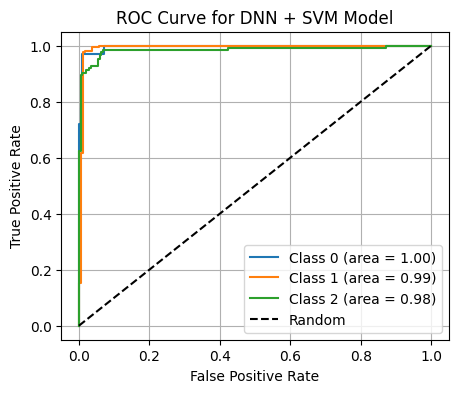

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC
test_labels_bin = label_binarize(test_labels_unsharp_masking, classes=[0, 1, 2])
n_classes = test_labels_bin.shape[1]

# Get predicted probabilities for each class
svm_probabilities_dnn_unsharp_masking = svm_model_dnn.predict_proba(test_features_dnn_unsharp_masking)

# Initialize the plot
plt.figure(figsize=(5,4))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], svm_probabilities_dnn_unsharp_masking[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DNN + SVM Model')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


# (V) CNN +SVM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),  # Flatten the feature maps
        Dense(128, activation='relu'),  # Dense layer for feature extraction
    ])
    return model

cnn_model = create_cnn_model()

# Extract features using the CNN
train_features_cnn_unsharp_masking = cnn_model.predict(train_images_unsharp_masking[..., np.newaxis])
test_features_cnn_unsharp_masking = cnn_model.predict(test_images_unsharp_masking[..., np.newaxis])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 787ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 564ms/step


In [ ]:
from sklearn.metrics import accuracy_score, log_loss

# Predict probabilities on the test set
svm_probabilities_cnn_unsharp_masking = svm_model.predict_proba(test_features_cnn_unsharp_masking)

# Predict class labels on the test set
svm_predictions_cnn_unsharp_masking  = svm_model.predict(test_features_cnn_unsharp_masking)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_cnn_unsharp_masking, train_labels_unsharp_masking)
# Calculate test accuracy
test_accuracy_cnn_unsharp_masking  = accuracy_score(test_labels_unsharp_masking, svm_predictions_cnn_unsharp_masking)
print(f"Test Accuracy: {test_accuracy_cnn_unsharp_masking }")

# Calculate test loss (log loss)
test_loss_cnn_unsharp_masking  = log_loss(test_labels_unsharp_masking, svm_probabilities_cnn_unsharp_masking)
print(f"Test Loss: {test_loss_cnn_unsharp_masking}")

Test Accuracy: 0.8606060606060606
Test Loss: 0.43408619928736214


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,precision_score, recall_score


# Standardize features
scaler = StandardScaler()
train_features_cnn_unsharp_masking = scaler.fit_transform(train_features_cnn_unsharp_masking)
test_features_cnn_unsharp_masking = scaler.transform(test_features_cnn_unsharp_masking)

# Generate the confusion matrix
cm = confusion_matrix(test_labels_unsharp_masking, svm_predictions_cnn_unsharp_masking)
# and then print them.
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_unsharp_masking, svm_predictions_cnn_unsharp_masking, labels=[i], average='macro')
    recall = recall_score(test_labels_unsharp_masking, svm_predictions_cnn_unsharp_masking, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Evaluate SVM model
svm_predictions_cnn_unsharp_masking = svm_model.predict(test_features_cnn_unsharp_masking)
print("SVM Classification Report:\n", classification_report(test_labels_unsharp_masking, svm_predictions_cnn_unsharp_masking))
print("SVM Confusion Matrix:\n", confusion_matrix(test_labels_unsharp_masking, svm_predictions_cnn_unsharp_masking))

Class 0:
  Precision: 0.79
  Recall (Sensitivity): 0.86
  Specificity: 0.97
  TP: 31, TN: 286, FP: 8, FN: 5

Class 1:
  Precision: 0.83
  Recall (Sensitivity): 0.99
  Specificity: 0.78
  TP: 167, TN: 126, FP: 35, FN: 2

Class 2:
  Precision: 0.97
  Recall (Sensitivity): 0.69
  Specificity: 0.99
  TP: 86, TN: 202, FP: 3, FN: 39

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.83        36
           1       0.83      0.99      0.90       169
           2       0.97      0.69      0.80       125

    accuracy                           0.86       330
   macro avg       0.86      0.85      0.84       330
weighted avg       0.88      0.86      0.86       330

SVM Confusion Matrix:
 [[ 31   3   2]
 [  1 167   1]
 [  7  32  86]]


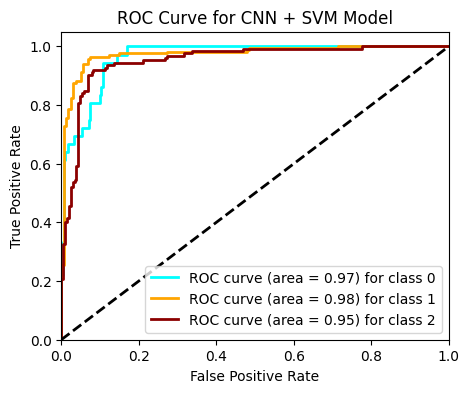

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities using the SVM model
svm_probabilities_cnn_unsharp_masking  = svm_model.predict_proba(test_features_cnn_unsharp_masking)

# Binarize the labels for multi-class ROC curve
n_classes = len(np.unique(test_labels_unsharp_masking))
test_labels_bin = label_binarize(test_labels_unsharp_masking, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_cnn_unsharp_masking [:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5, 4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN + SVM Model')
plt.legend(loc="lower right")
plt.show()


# (Vi) VGG16 + SVM

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, log_loss
import numpy as np

# Define VGG16 model as feature extractor
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Convert grayscale images to RGB
train_images_rgb_unsharp_masking = np.repeat(train_images_unsharp_masking[..., np.newaxis], 3, axis=-1)
test_images_rgb_unsharp_masking = np.repeat(test_images_unsharp_masking[..., np.newaxis], 3, axis=-1)

# Create and use VGG16 model to extract features
vgg16_model = create_vgg16_model()
train_features_vgg16_unsharp_masking = vgg16_model.predict(train_images_rgb_unsharp_masking)
test_features_vgg16_unsharp_masking = vgg16_model.predict(test_images_rgb_unsharp_masking)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 480s 20s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 219s 20s/step


In [ ]:
# Standardize features
scaler = StandardScaler()
train_features_vgg16_unsharp_masking = scaler.fit_transform(train_features_vgg16_unsharp_masking)
test_features_vgg16_unsharp_masking= scaler.transform(test_features_vgg16_unsharp_masking)

# Train SVM classifier
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_vgg16_unsharp_masking, train_labels_unsharp_masking)

# Predict class labels and probabilities
svm_predictions_vgg16_unsharp_masking = svm_model.predict(test_features_vgg16_unsharp_masking)
svm_probabilities_vgg16_unsharp_masking = svm_model.predict_proba(test_features_vgg16_unsharp_masking)

In [ ]:
# Calculate test accuracy
test_accuracy_vgg16_unsharp_masking = np.mean(svm_predictions_vgg16_unsharp_masking == test_labels_unsharp_masking)
print(f"Test Accuracy: {test_accuracy_vgg16_unsharp_masking:.2f}")

# Calculate test loss using log loss
test_loss_vgg16_unsharp_masking = log_loss(test_labels_unsharp_masking, svm_probabilities_vgg16_unsharp_masking)
print(f"Test Loss: {test_loss_vgg16_unsharp_masking:.2f}")

# Generate confusion matrix
cm = confusion_matrix(test_labels_unsharp_masking, svm_predictions_vgg16_unsharp_masking)

# Print confusion matrix
print("Confusion Matrix:\n", cm)

# Calculate TP, TN, FP, FN for each class
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_unsharp_masking, svm_predictions_vgg16_unsharp_masking, labels=[i], average='macro')
    recall = recall_score(test_labels_unsharp_masking, svm_predictions_vgg16_unsharp_masking, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Print classification report
print("Classification Report:\n", classification_report(test_labels_unsharp_masking, svm_predictions_vgg16_unsharp_masking))

Test Accuracy: 0.85
Test Loss: 0.36
Confusion Matrix:
 [[ 14  12  10]
 [  0 169   0]
 [  8  20  97]]
Class 0:
  Precision: 0.64
  Recall (Sensitivity): 0.39
  Specificity: 0.97
  TP: 14, TN: 286, FP: 8, FN: 22

Class 1:
  Precision: 0.84
  Recall (Sensitivity): 1.00
  Specificity: 0.80
  TP: 169, TN: 129, FP: 32, FN: 0

Class 2:
  Precision: 0.91
  Recall (Sensitivity): 0.78
  Specificity: 0.95
  TP: 97, TN: 195, FP: 10, FN: 28

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.39      0.48        36
           1       0.84      1.00      0.91       169
           2       0.91      0.78      0.84       125

    accuracy                           0.85       330
   macro avg       0.79      0.72      0.74       330
weighted avg       0.84      0.85      0.84       330



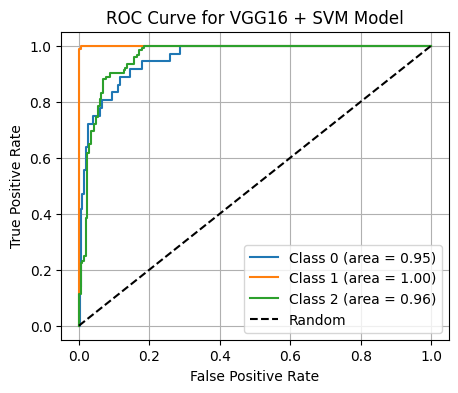

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC
test_labels_bin = label_binarize(test_labels_unsharp_masking, classes=[0, 1, 2])
n_classes = test_labels_bin.shape[1]

# Get predicted probabilities for each class
svm_probabilities_vgg16_unsharp_masking = svm_model.predict_proba(test_features_vgg16_unsharp_masking)

# Initialize the plot
plt.figure(figsize=(5,4))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], svm_probabilities_vgg16_unsharp_masking[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for VGG16 + SVM Model')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

# (vii) GoogleNet + SVM classifier

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

img_width, img_height = 224,224 # Required size for InceptionV3

# Step 1: Define the GoogLeNet (InceptionV3) model for feature extraction
def create_googlenet_feature_extractor():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)  # Output the features instead of classification
    return model

# Convert grayscale images to RGB if needed
train_images_rgb_unsharp_masking = np.repeat(train_images_unsharp_masking[..., np.newaxis], 3, axis=-1)
test_images_rgb_unsharp_masking = np.repeat(test_images_unsharp_masking[..., np.newaxis], 3, axis=-1)

# Step 2: Extract deep features using GoogLeNet (InceptionV3)
googlenet_feature_extractor = create_googlenet_feature_extractor()
train_features_unsharp_masking = googlenet_feature_extractor.predict(train_images_rgb_unsharp_masking)
test_features_unsharp_masking = googlenet_feature_extractor.predict(test_images_rgb_unsharp_masking)

# Step 3: Train the SVM on the extracted features
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
svm_classifier.fit(train_features_unsharp_masking, np.argmax(train_labels_cat_unsharp_masking, axis=1))

# Step 4: Evaluate the SVM model on the test data
test_predictions_unsharp_masking = svm_classifier.predict(test_features_unsharp_masking)
test_accuracy_unsharp_masking = np.mean(test_predictions_unsharp_masking == np.argmax(test_labels_cat_unsharp_masking, axis=1))

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions_unsharp_masking )
# and then print them.
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels, test_predictions_unsharp_masking , labels=[i], average='macro')
    recall = recall_score(test_labels, test_predictions_unsharp_masking , labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Step 5: Print evaluation metrics
print(f'Test Accuracy: {test_accuracy_unsharp_masking * 100:.2f}%')
print('Classification Report:')
print(classification_report(np.argmax(test_labels_cat_unsharp_masking, axis=1), test_predictions_unsharp_masking))
print('Confusion Matrix:')
print(confusion_matrix(np.argmax(test_labels_cat_unsharp_masking, axis=1), test_predictions_unsharp_masking))

24/24 ━━━━━━━━━━━━━━━━━━━━ 179s 7s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step
Class 0:
  Precision: 0.60
  Recall (Sensitivity): 0.58
  Specificity: 0.95
  TP: 21, TN: 280, FP: 14, FN: 15

Class 1:
  Precision: 0.93
  Recall (Sensitivity): 1.00
  Specificity: 0.92
  TP: 169, TN: 148, FP: 13, FN: 0

Class 2:
  Precision: 0.89
  Recall (Sensitivity): 0.81
  Specificity: 0.94
  TP: 101, TN: 193, FP: 12, FN: 24

Test Accuracy: 88.18%
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59        36
           1       0.93      1.00      0.96       169
           2       0.89      0.81      0.85       125

    accuracy                           0.88       330
   macro avg       0.81      0.80      0.80       330
weighted avg       0.88      0.88      0.88       330

Confusion Matrix:
[[ 21   3  12]
 [  0 169   0]
 [ 14  10 101]]


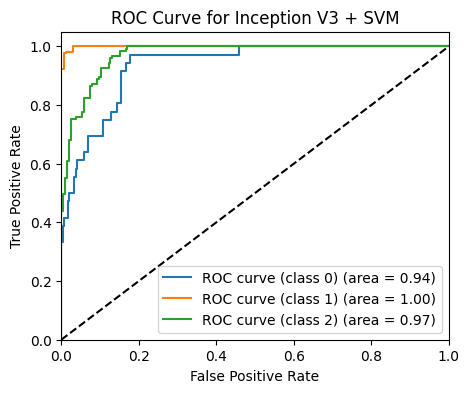

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Calculate ROC curve and AUC
svm_probabilities = svm_classifier.predict_proba(test_features_unsharp_masking)
fpr = {}
tpr = {}
roc_auc = {}

# Binarize the test labels for multi-class ROC
test_labels_bin = label_binarize(np.argmax(test_labels_cat_unsharp_masking, axis=1),
                                 classes=np.unique(np.argmax(test_labels_cat_unsharp_masking, axis=1)))
n_classes = test_labels_bin.shape[1]

# Calculate fpr, tpr, and roc_auc for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(5,4))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Inception V3 + SVM')
plt.legend(loc='lower right')
plt.show()

# Applying contrast stretching on all images

In [ ]:
import os
import cv2
import numpy as np

# Function to apply contrast stretching
def apply_contrast_stretching(img):
    # Get the minimum and maximum pixel values from the image
    min_val = np.min(img)
    max_val = np.max(img)

    # Apply contrast stretching
    stretched_img = ((img - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    return stretched_img

# Directory paths
input_train_dir = "/content/drive/MyDrive/IQ-OTHNCCD_split/train"
output_train_dir = "/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Training_Contrast_Stretched"

# Create output directory if it doesn't exist
if not os.path.exists(output_train_dir):
    os.makedirs(output_train_dir)

# Process and save contrast-stretched images
for category in ['benign', 'malignant', 'normal']:
    category_dir = os.path.join(input_train_dir, category)
    output_category_dir = os.path.join(output_train_dir, category)

    if not os.path.exists(output_category_dir):
        os.makedirs(output_category_dir)

    for filename in os.listdir(category_dir):
        img_path = os.path.join(category_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            img_stretched = apply_contrast_stretching(img)
            output_img_path = os.path.join(output_category_dir, filename)
            cv2.imwrite(output_img_path, img_stretched)
        else:
            print(f"Error loading image {img_path}")

print("Contrast stretching completed for all training images.")

Contrast stretching completed for all training images.


# Experimenting with contrast stretching images

**1. Setup Environment**

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow keras opencv-python

**2. Load and preprocess the data**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Directories
train_dir_contrast_stretching = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Training_Contrast_Stretched'
test_dir = '/content/drive/MyDrive/IQ-OTHNCCD_split/test'

# Image dimensions
img_width, img_height = 224, 224  # Adjust as needed

def load_images_from_directory(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            images.append(img)
            labels.append(label)
    return images, labels

# Load and prepare training and testing data
train_images_contrast_stretching, train_labels_contrast_stretching = [], []
for category, label in [('benign', 0), ('malignant', 1), ('normal', 2)]:
    category_images, category_labels = load_images_from_directory(os.path.join(train_dir_contrast_stretching, category), label)
    train_images_contrast_stretching.extend(category_images)
    train_labels_contrast_stretching.extend(category_labels)

test_images_contrast_stretching, test_labels_contrast_stretching = [], []
for category, label in [('benign', 0), ('malignant', 1), ('normal', 2)]:
    category_images, category_labels = load_images_from_directory(os.path.join(test_dir, category), label)
    test_images_contrast_stretching.extend(category_images)
    test_labels_contrast_stretching.extend(category_labels)

# Convert lists to arrays and normalize
train_images_contrast_stretching = np.array(train_images_contrast_stretching).astype('float32') / 255.0
test_images_contrast_stretching = np.array(test_images_contrast_stretching).astype('float32') / 255.0
train_labels_contrast_stretching = np.array(train_labels_contrast_stretching)
test_labels_contrast_stretching = np.array(test_labels_contrast_stretching)

# Convert labels to categorical format
train_labels_cat_contrast_stretching = to_categorical(train_labels_contrast_stretching, num_classes=3)
test_labels_cat_contrast_stretching = to_categorical(test_labels_contrast_stretching, num_classes=3)

# (i) LeNet-5 + SVM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten

# Create LeNet-5 model for feature extraction
def create_lenet5_feature_extractor():
    model = Sequential([
        Conv2D(6, (5, 5), activation='tanh', input_shape=(img_width, img_height, 1)),
        MaxPooling2D(),
        Conv2D(16, (5, 5), activation='tanh'),
        MaxPooling2D(),
        Flatten(),  # Flatten the feature maps
        Dense(120, activation='tanh'),
        Dense(84, activation='tanh'),
    ])
    return model

lenet5_feature_extractor = create_lenet5_feature_extractor()

# Extract features using LeNet-5
train_features_lenet5_contrast_stretching = lenet5_feature_extractor.predict(train_images_contrast_stretching[..., np.newaxis])
test_features_lenet5_contrast_stretching = lenet5_feature_extractor.predict(test_images_contrast_stretching[..., np.newaxis])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
train_features_lenet5_contrast_stretching = scaler.fit_transform(train_features_lenet5_contrast_stretching)
test_features_lenet5_contrast_stretching = scaler.transform(test_features_lenet5_contrast_stretching)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_lenet5_contrast_stretching, train_labels_contrast_stretching)

SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict probabilities and class labels on the test set
svm_probabilities_lenet5_contrast_stretching = svm_model.predict_proba(test_features_lenet5_contrast_stretching)
svm_predictions_lenet5_contrast_stretching = svm_model.predict(test_features_lenet5_contrast_stretching)

# Calculate test accuracy
test_accuracy_lenet5_contrast_stretching = accuracy_score(test_labels_contrast_stretching, svm_predictions_lenet5_contrast_stretching)
print(f"Test Accuracy: {test_accuracy_lenet5_contrast_stretching}")

# Calculate test loss (log loss)
test_loss_lenet5_contrast_stretching = log_loss(test_labels_contrast_stretching, svm_probabilities_lenet5_contrast_stretching)
print(f"Test Loss: {test_loss_lenet5_contrast_stretching}")

# Print the classification report
print("Classification Report for LeNet-5 + SVM Model:\n")
print(classification_report(test_labels_contrast_stretching, svm_predictions_lenet5_contrast_stretching))

# Generate the confusion matrix
cm = confusion_matrix(test_labels_contrast_stretching, svm_predictions_lenet5_contrast_stretching)

# For a multi-class problem, we'll compute metrics for each class individually
# and then print them.
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_contrast_stretching, svm_predictions_lenet5_contrast_stretching, labels=[i], average='macro')
    recall = recall_score(test_labels_contrast_stretching, svm_predictions_lenet5_contrast_stretching, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()


Test Accuracy: 0.8545454545454545
Test Loss: 0.437269720715503
Classification Report for LeNet-5 + SVM Model:

              precision    recall  f1-score   support

           0       0.80      0.33      0.47        36
           1       0.90      0.95      0.92       169
           2       0.80      0.88      0.84       125

    accuracy                           0.85       330
   macro avg       0.83      0.72      0.74       330
weighted avg       0.85      0.85      0.84       330

Class 0:
  Precision: 0.80
  Recall (Sensitivity): 0.33
  Specificity: 0.99
  TP: 12, TN: 291, FP: 3, FN: 24

Class 1:
  Precision: 0.90
  Recall (Sensitivity): 0.95
  Specificity: 0.89
  TP: 160, TN: 144, FP: 17, FN: 9

Class 2:
  Precision: 0.80
  Recall (Sensitivity): 0.88
  Specificity: 0.86
  TP: 110, TN: 177, FP: 28, FN: 15



Test Accuracy: 0.8545454545454545
Test Loss: 0.437269720715503


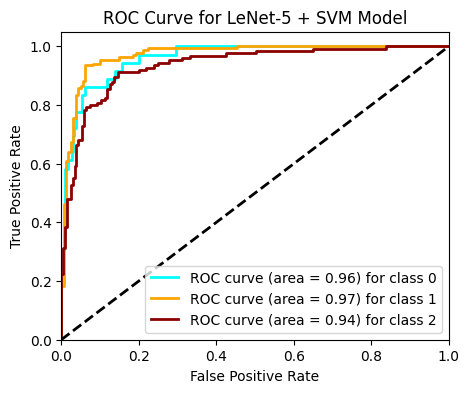

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Calculate test accuracy
test_accuracy_lenet5_contrast_stretching = accuracy_score(test_labels_contrast_stretching, svm_predictions_lenet5_contrast_stretching)
print(f"Test Accuracy: {test_accuracy_lenet5_contrast_stretching}")

# Calculate test loss (log loss)
test_loss_lenet5_contrast_stretching = log_loss(test_labels_contrast_stretching, svm_probabilities_lenet5_contrast_stretching)
print(f"Test Loss: {test_loss_lenet5_contrast_stretching}")
#  3 classes
n_classes = len(np.unique(test_labels_contrast_stretching))

# Binarize the labels for multi-class ROC curve
test_labels_bin = label_binarize(test_labels_contrast_stretching, classes=[0, 1, 2])

# Predict probabilities using the SVM model
svm_probabilities_contrast_stretching = svm_model.predict_proba(test_features_lenet5_contrast_stretching)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_contrast_stretching[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5,4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LeNet-5 + SVM Model')
plt.legend(loc="lower right")
plt.show()

# (ii) DenseNet-121 + SVM

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the DenseNet121 model
def create_densenet121_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Convert grayscale images to RGB
train_images_rgb_contrast_stretching = np.repeat(train_images_contrast_stretching[..., np.newaxis], 3, axis=-1)
test_images_rgb_contrast_stretching = np.repeat(test_images_contrast_stretching[..., np.newaxis], 3, axis=-1)

# Load DenseNet121 model and extract features
densenet121_model_contrast_stretching = create_densenet121_model()
feature_extractor_contrast_stretching = Model(inputs=densenet121_model_contrast_stretching.input, outputs=densenet121_model_contrast_stretching.layers[-2].output)

# Extract features
train_features_densenet121_contrast_stretching = feature_extractor_contrast_stretching.predict(train_images_rgb_contrast_stretching)
test_features_densenet121_contrast_stretching = feature_extractor_contrast_stretching.predict(test_images_rgb_contrast_stretching)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

# Standardize features
scaler = StandardScaler()
train_features_densenet121_contrast_stretching = scaler.fit_transform(train_features_densenet121_contrast_stretching)
test_features_densenet121_contrast_stretching = scaler.transform(test_features_densenet121_contrast_stretching)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_densenet121_contrast_stretching, train_labels_contrast_stretching)

SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, log_loss
import numpy as np

# Predict class labels and probabilities using the SVM model
svm_predictions_densenet121_contrast_stretching = svm_model.predict(test_features_densenet121_contrast_stretching)
svm_probabilities_densenet121_contrast_stretching= svm_model.predict_proba(test_features_densenet121_contrast_stretching)

# Calculate overall accuracy
test_accuracy_densenet121_contrast_stretching= accuracy_score(test_labels_contrast_stretching, svm_predictions_densenet121_contrast_stretching)
print(f"Test Accuracy: {test_accuracy_densenet121_contrast_stretching:.2f}")

# Binarize the labels for multi-class ROC curve
test_labels_bin = label_binarize(test_labels_contrast_stretching, classes=[0, 1, 2])

# Calculate test loss (log loss)
test_loss_densenet121_contrast_stretching = log_loss(test_labels_bin, svm_probabilities_densenet121_contrast_stretching)
print(f"Test Loss: {test_loss_densenet121_contrast_stretching:.2f}")

# Print the classification report
print("Classification Report for DenseNet121 + SVM Model:\n")
print(classification_report(test_labels_contrast_stretching, svm_predictions_densenet121_contrast_stretching))

# Calculate the confusion matrix
cm = confusion_matrix(test_labels_contrast_stretching, svm_predictions_densenet121_contrast_stretching)

# For multi-class problems, calculate metrics for each class
n_classes = len(np.unique(test_labels_contrast_stretching))
for i in range(n_classes):
    tp = cm[i, i]  # True Positives for class i
    fp = cm[:, i].sum() - tp  # False Positives for class i
    fn = cm[i, :].sum() - tp  # False Negatives for class i
    tn = cm.sum() - (tp + fp + fn)  # True Negatives for class i

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_contrast_stretching, svm_predictions_densenet121_contrast_stretching, labels=[i], average='macro')
    recall = recall_score(test_labels_contrast_stretching, svm_predictions_densenet121_contrast_stretching, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Print confusion matrix
print("Confusion Matrix:\n", cm)


Test Accuracy: 0.95
Test Loss: 0.17
Classification Report for DenseNet121 + SVM Model:

              precision    recall  f1-score   support

           0       0.83      0.69      0.76        36
           1       0.98      1.00      0.99       169
           2       0.93      0.94      0.94       125

    accuracy                           0.95       330
   macro avg       0.91      0.88      0.89       330
weighted avg       0.94      0.95      0.94       330

Class 0:
  Precision: 0.83
  Recall (Sensitivity): 0.69
  Specificity: 0.98
  TP: 25, TN: 289, FP: 5, FN: 11

Class 1:
  Precision: 0.98
  Recall (Sensitivity): 1.00
  Specificity: 0.98
  TP: 169, TN: 157, FP: 4, FN: 0

Class 2:
  Precision: 0.93
  Recall (Sensitivity): 0.94
  Specificity: 0.96
  TP: 118, TN: 196, FP: 9, FN: 7

Confusion Matrix:
 [[ 25   2   9]
 [  0 169   0]
 [  5   2 118]]


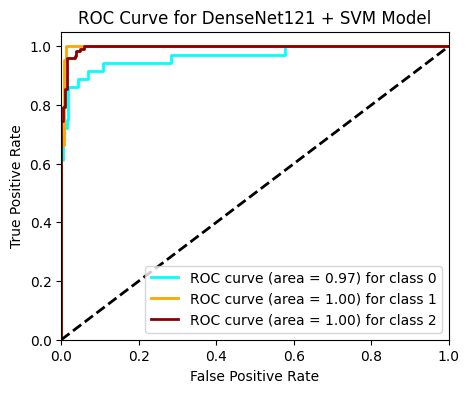

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities using the SVM model
svm_probabilities_densenet121_contrast_stretching = svm_model.predict_proba(test_features_densenet121_contrast_stretching)

# Binarize the labels for multi-class ROC curve
n_classes = len(np.unique(test_labels_contrast_stretching))
test_labels_bin = label_binarize(test_labels_contrast_stretching, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_densenet121_contrast_stretching[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5, 4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DenseNet121 + SVM Model')
plt.legend(loc="lower right")
plt.show()


# (iii) ResNet50 + SVM

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert grayscale images to RGB
train_images_rgb_contrast_stretching = np.repeat(train_images_contrast_stretching[..., np.newaxis], 3, axis=-1)
test_images_rgb_contrast_stretching = np.repeat(test_images_contrast_stretching[..., np.newaxis], 3, axis=-1)

# Initialize and train the ResNet50 model
resnet50_model = create_resnet50_model()

# Extract features using the ResNet50 model
feature_extractor_resnet50_contrast_stretching = Model(inputs=resnet50_model.input, outputs=resnet50_model.layers[-2].output)
train_features_resnet50_contrast_stretching = feature_extractor_resnet50_contrast_stretching.predict(train_images_rgb_contrast_stretching)
test_features_resnet50_contrast_stretching = feature_extractor_resnet50_contrast_stretching.predict(test_images_rgb_contrast_stretching)


24/24 ━━━━━━━━━━━━━━━━━━━━ 228s 10s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step


In [ ]:
# Standardize features
scaler = StandardScaler()
train_features_resnet50_contrast_stretching = scaler.fit_transform(train_features_resnet50_contrast_stretching)
test_features_resnet50_contrast_stretching = scaler.transform(test_features_resnet50_contrast_stretching)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_resnet50_contrast_stretching, train_labels_contrast_stretching)

SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, log_loss

# Predict probabilities and class labels on the test set
svm_probabilities_resnet50_contrast_stretching = svm_model.predict_proba(test_features_resnet50_contrast_stretching)
svm_predictions_resnet50_contrast_stretching = svm_model.predict(test_features_resnet50_contrast_stretching)

# Calculate test accuracy
test_accuracy_resnet50_contrast_stretching = accuracy_score(test_labels_contrast_stretching, svm_predictions_resnet50_contrast_stretching)
print(f"Test Accuracy: {test_accuracy_resnet50_contrast_stretching:.2f}")

# Calculate test loss (log loss)
test_loss_resnet50_contrast_stretching = log_loss(test_labels_contrast_stretching, svm_probabilities_resnet50_contrast_stretching)
print(f"Test Loss: {test_loss_resnet50_contrast_stretching:.2f}")

# Print classification report
print("\nClassification Report:\n", classification_report(test_labels_contrast_stretching, svm_predictions_resnet50_contrast_stretching))

# Compute confusion matrix
cm = confusion_matrix(test_labels_contrast_stretching, svm_predictions_resnet50_contrast_stretching)

# Compute precision, recall, sensitivity, specificity
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_contrast_stretching, svm_predictions_resnet50_contrast_stretching, labels=[i], average='macro')
    recall = recall_score(test_labels_contrast_stretching, svm_predictions_resnet50_contrast_stretching, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero

    print(f"\nClass {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

Test Accuracy: 0.78
Test Loss: 0.79

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.36      0.44        36
           1       0.79      0.95      0.86       169
           2       0.82      0.67      0.74       125

    accuracy                           0.78       330
   macro avg       0.72      0.66      0.68       330
weighted avg       0.77      0.78      0.77       330


Class 0:
  Precision: 0.57
  Recall (Sensitivity): 0.36
  Specificity: 0.97
  TP: 13, TN: 284, FP: 10, FN: 23

Class 1:
  Precision: 0.79
  Recall (Sensitivity): 0.95
  Specificity: 0.73
  TP: 161, TN: 118, FP: 43, FN: 8

Class 2:
  Precision: 0.82
  Recall (Sensitivity): 0.67
  Specificity: 0.91
  TP: 84, TN: 186, FP: 19, FN: 41


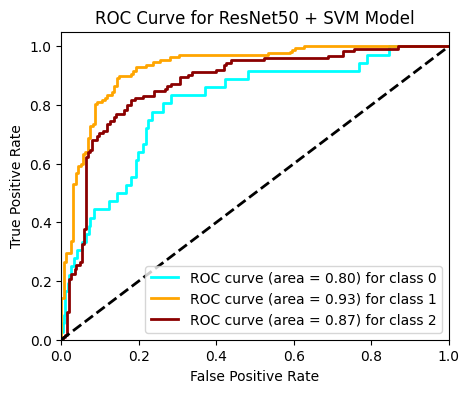

In [ ]:
# Binarize the labels for multi-class ROC curve
test_labels_bin = label_binarize(test_labels_contrast_stretching, classes=[0, 1, 2])

# Predict probabilities using the SVM model
svm_probabilities_resnet50_contrast_stretching = svm_model.predict_proba(test_features_resnet50_contrast_stretching)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(test_labels_bin[0])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_resnet50_contrast_stretching[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5,4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ResNet50 + SVM Model')
plt.legend(loc="lower right")
plt.show()

# (iV) Deep Neural Network (DNN) + SVM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Define the Deep Neural Network (DNN) model
def create_dnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(3, activation='softmax')(x)  # Assuming 3 classes
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Flatten images
train_images_flatten_contrast_stretching = train_images_contrast_stretching .reshape((train_images_contrast_stretching .shape[0], -1))
test_images_flatten_contrast_stretching  = test_images_contrast_stretching .reshape((test_images_contrast_stretching .shape[0], -1))

# Train the DNN model
input_shape = (train_images_flatten_contrast_stretching .shape[1],)  # Flattened input shape
dnn_model = create_dnn_model(input_shape)
dnn_model.fit(train_images_flatten_contrast_stretching , train_labels_cat_contrast_stretching , epochs=10, batch_size=32, validation_split=0.2)

# Create a feature extraction model
feature_extractor_dnn_contrast_stretching = Model(inputs=dnn_model.input, outputs=dnn_model.layers[-2].output)

# Extract features
train_features_dnn_contrast_stretching = feature_extractor_dnn_contrast_stretching .predict(train_images_flatten_contrast_stretching)
test_features_dnn_contrast_stretching  = feature_extractor_dnn_contrast_stretching .predict(test_images_flatten_contrast_stretching)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.4187 - loss: 2.3594 - val_accuracy: 0.9870 - val_loss: 0.0861
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.7279 - loss: 1.2175 - val_accuracy: 0.2468 - val_loss: 1.9700
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8499 - loss: 0.4162 - val_accuracy: 0.1883 - val_loss: 3.3128
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9117 - loss: 0.2176 - val_accuracy: 0.2208 - val_loss: 2.4760
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9953 - loss: 0.0523 - val_accuracy: 0.3117 - val_loss: 2.1719
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9953 - loss: 0.0363 - val_accuracy: 0.2922 - val_loss: 2.6755
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0270 - val_accuracy: 0.2922 - val_loss: 2.5795
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 0.2922 -

In [ ]:
# Train the SVM model
scaler = StandardScaler()
train_features_dnn_contrast_stretching = scaler.fit_transform(train_features_dnn_contrast_stretching)
test_features_dnn_contrast_stretching = scaler.transform(test_features_dnn_contrast_stretching)

svm_model_dnn = SVC(kernel='linear', probability=True)
svm_model_dnn.fit(train_features_dnn_contrast_stretching, train_labels_contrast_stretching)

# Predict class labels on the test set
svm_predictions_dnn_contrast_stretching = svm_model_dnn.predict(test_features_dnn_contrast_stretching)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

# Predict class labels on the test set
svm_predictions_dnn_contrast_stretching = svm_model_dnn.predict(test_features_dnn_contrast_stretching)
svm_probabilities_dnn_contrast_stretching = svm_model_dnn.predict_proba(test_features_dnn_contrast_stretching)

# Print test loss and accuracy
# For SVM, we don't have loss during prediction, so we will use accuracy
test_accuracy_dnn_contrast_stretching = np.mean(svm_predictions_dnn_contrast_stretching == test_labels_contrast_stretching)
print(f"Test Accuracy: {test_accuracy_dnn_contrast_stretching:.2f}")

# SVM does not have a direct 'loss' measure like neural networks
# We use log_loss as an approximation for the test loss
from sklearn.metrics import log_loss
test_loss_dnn_contrast_stretching = log_loss(test_labels_contrast_stretching, svm_probabilities_dnn_contrast_stretching)
print(f"Test Loss: {test_loss_dnn_contrast_stretching:.2f}")

# Print classification report
print("SVM Classification Report:\n", classification_report(test_labels_contrast_stretching, svm_predictions_dnn_contrast_stretching))

# Generate the confusion matrix
cm = confusion_matrix(test_labels_contrast_stretching, svm_predictions_dnn_contrast_stretching)

# Calculate precision, recall (sensitivity), specificity for each class
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_contrast_stretching, svm_predictions_dnn_contrast_stretching, labels=[i], average='macro')
    recall = recall_score(test_labels_contrast_stretching, svm_predictions_dnn_contrast_stretching, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

Test Accuracy: 0.87
Test Loss: 0.90
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.98      0.98      0.98       169
           2       0.75      0.97      0.85       125

    accuracy                           0.87       330
   macro avg       0.58      0.65      0.61       330
weighted avg       0.78      0.87      0.82       330

Class 0:
  Precision: 0.00
  Recall (Sensitivity): 0.00
  Specificity: 1.00
  TP: 0, TN: 294, FP: 0, FN: 36

Class 1:
  Precision: 0.98
  Recall (Sensitivity): 0.98
  Specificity: 0.98
  TP: 165, TN: 157, FP: 4, FN: 4

Class 2:
  Precision: 0.75
  Recall (Sensitivity): 0.97
  Specificity: 0.80
  TP: 121, TN: 165, FP: 40, FN: 4



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

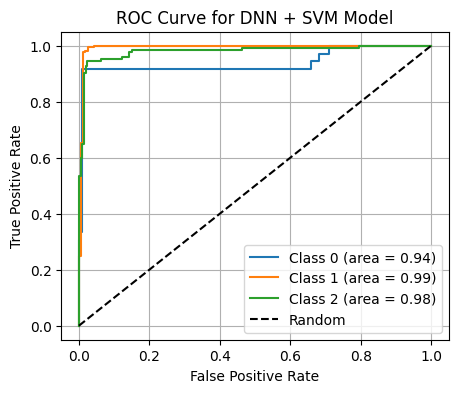

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC
test_labels_bin = label_binarize(test_labels_contrast_stretching, classes=[0, 1, 2])
n_classes = test_labels_bin.shape[1]

# Get predicted probabilities for each class
svm_probabilities_dnn_contrast_stretching = svm_model_dnn.predict_proba(test_features_dnn_contrast_stretching)

# Initialize the plot
plt.figure(figsize=(5,4))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], svm_probabilities_dnn_contrast_stretching[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DNN + SVM Model')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


# CNN + SVM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),  # Flatten the feature maps
        Dense(128, activation='relu'),  # Dense layer for feature extraction
    ])
    return model

cnn_model = create_cnn_model()

# Extract features using the CNN
train_features_cnn_contrast_stretching = cnn_model.predict(train_images_contrast_stretching[..., np.newaxis])
test_features_cnn_contrast_stretching = cnn_model.predict(test_images_contrast_stretching[..., np.newaxis])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 828ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 801ms/step


In [ ]:
from sklearn.metrics import accuracy_score, log_loss

# Predict probabilities on the test set
svm_probabilities_cnn_contrast_stretching = svm_model.predict_proba(test_features_cnn_contrast_stretching)

# Predict class labels on the test set
svm_predictions_cnn_contrast_stretching  = svm_model.predict(test_features_cnn_contrast_stretching)

# Standardize features
scaler = StandardScaler()
train_features_cnn_contrast_stretching = scaler.fit_transform(train_features_cnn_contrast_stretching)
test_features_cnn_contrast_stretching = scaler.transform(test_features_cnn_contrast_stretching)

# Train SVM model on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_cnn_contrast_stretching, train_labels_contrast_stretching)

# Calculate test accuracy
test_accuracy_cnn_contrast_stretching  = accuracy_score(test_labels_contrast_stretching, svm_predictions_cnn_contrast_stretching)
print(f"Test Accuracy: {test_accuracy_cnn_contrast_stretching}")

# Calculate test loss (log loss)
test_loss_cnn_contrast_stretching  = log_loss(test_labels_contrast_stretching, svm_probabilities_cnn_contrast_stretching)
print(f"Test Loss: {test_loss_cnn_contrast_stretching}")

Test Accuracy: 0.7454545454545455
Test Loss: 0.5336193332936928


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(test_labels_contrast_stretching, svm_predictions_cnn_contrast_stretching)

# Calculate TP, TN, FP, FN for each class
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_contrast_stretching, svm_predictions_cnn_contrast_stretching, labels=[i], average='macro')
    recall = recall_score(test_labels_contrast_stretching, svm_predictions_cnn_contrast_stretching, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()


# Evaluate SVM model
svm_predictions_cnn_contrast_stretching = svm_model.predict(test_features_cnn_contrast_stretching)
print("SVM Classification Report:\n", classification_report(test_labels_contrast_stretching, svm_predictions_cnn_contrast_stretching))
print("SVM Confusion Matrix:\n", confusion_matrix(test_labels_contrast_stretching, svm_predictions_cnn_contrast_stretching))

Class 0:
  Precision: 0.81
  Recall (Sensitivity): 0.72
  Specificity: 0.98
  TP: 26, TN: 288, FP: 6, FN: 10

Class 1:
  Precision: 0.95
  Recall (Sensitivity): 0.80
  Specificity: 0.96
  TP: 135, TN: 154, FP: 7, FN: 34

Class 2:
  Precision: 0.73
  Recall (Sensitivity): 0.91
  Specificity: 0.80
  TP: 114, TN: 163, FP: 42, FN: 11

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76        36
           1       0.95      0.80      0.87       169
           2       0.73      0.91      0.81       125

    accuracy                           0.83       330
   macro avg       0.83      0.81      0.81       330
weighted avg       0.85      0.83      0.84       330

SVM Confusion Matrix:
 [[ 26   0  10]
 [  2 135  32]
 [  4   7 114]]


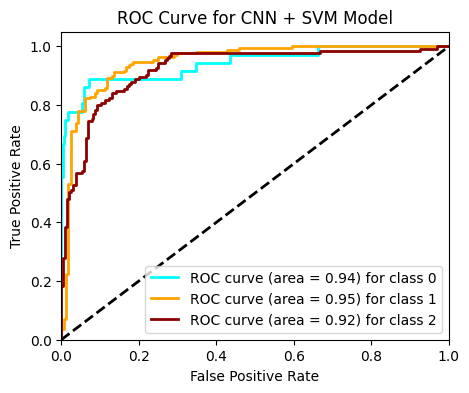

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities using the SVM model
svm_probabilities_cnn_contrast_stretching  = svm_model.predict_proba(test_features_cnn_contrast_stretching)

# Binarize the labels for multi-class ROC curve
n_classes = len(np.unique(test_labels_contrast_stretching))
test_labels_bin = label_binarize(test_labels_contrast_stretching, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], svm_probabilities_cnn_contrast_stretching [:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5, 4))
colors = ['aqua', 'orange', 'darkred']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN + SVM Model')
plt.legend(loc="lower right")
plt.show()


# (vi) VGG16 + SVM

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, log_loss
import numpy as np

# Define VGG16 model as feature extractor
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Convert grayscale images to RGB
train_images_rgb_contrast_stretching = np.repeat(train_images_contrast_stretching[..., np.newaxis], 3, axis=-1)
test_images_rgb_contrast_stretching = np.repeat(test_images_contrast_stretching[..., np.newaxis], 3, axis=-1)

# Create and use VGG16 model to extract features
vgg16_model = create_vgg16_model()
train_features_vgg16_contrast_stretching = vgg16_model.predict(train_images_rgb_contrast_stretching)
test_features_vgg16_contrast_stretching = vgg16_model.predict(test_images_rgb_contrast_stretching)

24/24 ━━━━━━━━━━━━━━━━━━━━ 632s 27s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 207s 18s/step


In [ ]:
# Standardize features
scaler = StandardScaler()
train_features_vgg16_contrast_stretching = scaler.fit_transform(train_features_vgg16_contrast_stretching)
test_features_vgg16_contrast_stretching = scaler.transform(test_features_vgg16_contrast_stretching)

# Train SVM classifier
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features_vgg16_contrast_stretching, train_labels_contrast_stretching)

# Predict class labels and probabilities
svm_predictions_vgg16_contrast_stretching = svm_model.predict(test_features_vgg16_contrast_stretching)
svm_probabilities_vgg16_contrast_stretching = svm_model.predict_proba(test_features_vgg16_contrast_stretching)


In [ ]:
# Calculate test accuracy
test_accuracy_vgg16_contrast_stretching = np.mean(svm_predictions_vgg16_contrast_stretching == test_labels_contrast_stretching)
print(f"Test Accuracy: {test_accuracy_vgg16_contrast_stretching:.2f}")

# Calculate test loss using log loss
test_loss_vgg16_contrast_stretching = log_loss(test_labels_contrast_stretching, svm_probabilities_vgg16_contrast_stretching)
print(f"Test Loss: {test_loss_vgg16_contrast_stretching:.2f}")

# Generate confusion matrix
cm = confusion_matrix(test_labels_contrast_stretching, svm_predictions_vgg16_contrast_stretching)

# Print confusion matrix
print("Confusion Matrix:\n", cm)

# Calculate TP, TN, FP, FN for each class
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_contrast_stretching, svm_predictions_vgg16_contrast_stretching, labels=[i], average='macro')
    recall = recall_score(test_labels_contrast_stretching, svm_predictions_vgg16_contrast_stretching, labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Print classification report
print("Classification Report:\n", classification_report(test_labels_contrast_stretching, svm_predictions_vgg16_contrast_stretching))

Test Accuracy: 0.95
Test Loss: 0.15
Confusion Matrix:
 [[ 25   0  11]
 [  0 168   1]
 [  5   1 119]]
Class 0:
  Precision: 0.83
  Recall (Sensitivity): 0.69
  Specificity: 0.98
  TP: 25, TN: 289, FP: 5, FN: 11

Class 1:
  Precision: 0.99
  Recall (Sensitivity): 0.99
  Specificity: 0.99
  TP: 168, TN: 160, FP: 1, FN: 1

Class 2:
  Precision: 0.91
  Recall (Sensitivity): 0.95
  Specificity: 0.94
  TP: 119, TN: 193, FP: 12, FN: 6

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.76        36
           1       0.99      0.99      0.99       169
           2       0.91      0.95      0.93       125

    accuracy                           0.95       330
   macro avg       0.91      0.88      0.89       330
weighted avg       0.94      0.95      0.94       330



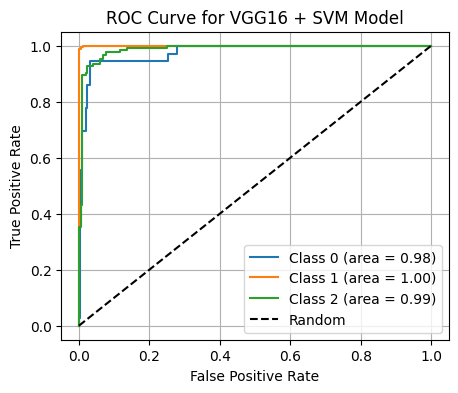

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC
test_labels_bin = label_binarize(test_labels_contrast_stretching, classes=[0, 1, 2])
n_classes = test_labels_bin.shape[1]

# Get predicted probabilities for each class
svm_probabilities_vgg16_contrast_stretching = svm_model.predict_proba(test_features_vgg16_contrast_stretching)

# Initialize the plot
plt.figure(figsize=(5,4))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], svm_probabilities_vgg16_contrast_stretching[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for VGG16 + SVM Model')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

# (vii) GoogleNet + SVM classifier

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

img_width, img_height = 224,224 # Required size for InceptionV3

# Step 1: Define the GoogLeNet (InceptionV3) model for feature extraction
def create_googlenet_feature_extractor():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)  # Output the features instead of classification
    return model

# Convert grayscale images to RGB if needed
train_images_rgb_contrast_stretching = np.repeat(train_images_contrast_stretching[..., np.newaxis], 3, axis=-1)
test_images_rgb_contrast_stretching = np.repeat(test_images_contrast_stretching[..., np.newaxis], 3, axis=-1)

# Step 2: Extract deep features using GoogLeNet (InceptionV3)
googlenet_feature_extractor = create_googlenet_feature_extractor()
train_features_contrast_stretching = googlenet_feature_extractor.predict(train_images_rgb_contrast_stretching)
test_features_contrast_stretching = googlenet_feature_extractor.predict(test_images_rgb_contrast_stretching)

# Step 3: Train the SVM on the extracted features
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
svm_classifier.fit(train_features_contrast_stretching, np.argmax(train_labels_cat_contrast_stretching, axis=1))

# Step 4: Evaluate the SVM model on the test data
test_predictions_contrast_stretching = svm_classifier.predict(test_features_contrast_stretching)
test_accuracy_contrast_stretching = np.mean(test_predictions_contrast_stretching == np.argmax(test_labels_cat_contrast_stretching, axis=1))

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions_contrast_stretching )
# and then print them.
for i in range(len(cm)):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Calculate precision, recall (sensitivity), and specificity
    precision = precision_score(test_labels_contrast_stretching, test_predictions_contrast_stretching , labels=[i], average='macro')
    recall = recall_score(test_labels_contrast_stretching, test_predictions_contrast_stretching , labels=[i], average='macro')  # Sensitivity
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall (Sensitivity): {recall:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print()

# Step 5: Print evaluation metrics
print(f'Test Accuracy: {test_accuracy_contrast_stretching * 100:.2f}%')
print('Classification Report:')
print(classification_report(np.argmax(test_labels_cat_contrast_stretching, axis=1), test_predictions_contrast_stretching))
print('Confusion Matrix:')
print(confusion_matrix(np.argmax(test_labels_cat_contrast_stretching, axis=1), test_predictions_contrast_stretching))

24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step
Class 0:
  Precision: 0.71
  Recall (Sensitivity): 0.67
  Specificity: 0.97
  TP: 24, TN: 284, FP: 10, FN: 12

Class 1:
  Precision: 0.98
  Recall (Sensitivity): 0.99
  Specificity: 0.98
  TP: 167, TN: 157, FP: 4, FN: 2

Class 2:
  Precision: 0.90
  Recall (Sensitivity): 0.90
  Specificity: 0.94
  TP: 113, TN: 193, FP: 12, FN: 12

Test Accuracy: 92.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        36
           1       0.98      0.99      0.98       169
           2       0.90      0.90      0.90       125

    accuracy                           0.92       330
   macro avg       0.86      0.85      0.86       330
weighted avg       0.92      0.92      0.92       330

Confusion Matrix:
[[ 24   1  11]
 [  1 167   1]
 [  9   3 113]]


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt


# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels_cat_contrast_stretching, axis=1), test_predictions_contrast_stretching)
tp=conf_matrix[1,1]
fp=conf_matrix[0,1]
fn=conf_matrix[1,0]
tp=conf_matrix[0,0]

# Calculate metrics
accuracy = accuracy_score(np.argmax(test_labels_cat_contrast_stretching, axis=1), test_predictions_contrast_stretching)
precision = precision_score(np.argmax(test_labels_cat_contrast_stretching, axis=1), test_predictions_contrast_stretching, average='weighted')
recall = recall_score(np.argmax(test_labels_cat_contrast_stretching, axis=1), test_predictions_contrast_stretching, average='weighted')
sensitivity = recall  # Sensitivity is the same as recall
specificity = tn / (tn + fp)

# Print the metrics
print(f'Precision: {precision:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'True Positives (TP): {tp}')
print(f'True Negatives (TN): {tn}')
print(f'False Positives (FP): {fp}')
print(f'False Negatives (FN): {fn}')

# Calculate ROC curve and AUC
svm_probabilities = svm_classifier.predict_proba(test_features_contrast_stretching)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(np.unique(np.argmax(test_labels_cat_contrast_stretching, axis=1)))):
    fpr[i], tpr[i], _ = roc_curve(np.argmax(test_labels_cat_contrast_stretching, axis=1) == i, svm_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Precision: 0.92
Accuracy: 0.92
Recall: 0.92
Sensitivity: 0.92
Specificity: 0.99
True Positives (TP): 24
True Negatives (TN): 165
False Positives (FP): 1
False Negatives (FN): 1


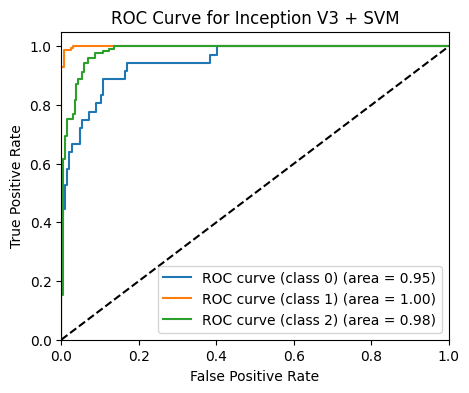

In [ ]:
# Plot ROC curve
plt.figure(figsize=(5,4))
for i in range(len(np.unique(np.argmax(test_labels_cat_contrast_stretching, axis=1)))):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Inception V3 + SVM')
plt.legend(loc='lower right')
plt.show()